### Import libraries

In [1]:
import os # Operating system operations
import shutil as st # Copy operations
import numpy as np # Array and vector-matrix operations
import random # Shuffle datas
import pickle # Save and load history files
import cv2 # Resize images
import matplotlib.image as mping # Read RGB images
import seaborn # Confusion matrix display
import pandas as pd # Data reading
import matplotlib.pyplot as plt # Visualition
import skimage # Loading images
import keras_tuner as kt # Hyperparameter optimization


# Required packages for our ConvNet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet152,  DenseNet201, MobileNetV2, EfficientNetB0, EfficientNetB7
from tensorflow.keras.utils import Sequence
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score,  precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc

# Required packages for extracting files, progression bar etc.
from tqdm.auto import tqdm
from io import BytesIO
from zipfile import ZipFile
from pathlib import Path
from shutil import copyfileobj
from tqdm.utils import CallbackIOWrapper
from os import fspath

### Downloading and extracting the dataset

The following section will download the necessarry dataset and the models. The 'Datas' folder contains:
 - Training set: Images for the training process (8512)
 - Validation set: Images for validation (751)
 - Test set: Images for testing (752)
 - Gaussian test set: Test set images with Gaussian noise
 - Poisson test set: Test set images with Poisson noise
 - test: Test images for check the CNN confidence

The models folder contains:
 - default models: The default models. They have been trained with transfer learning (all layers frozen, feature extraction)
 - optimized models: The optimized models. They have been trained with transfer learning (some layers were newly trained and optimized)
 - ensemble models: The final model with ensemble technique.

Helper function for creating directories, extracting files with progression bar.

In [2]:
def create_folders():
    
    models_dir                = 'new_models'
    metrics_dir               = 'metrics'
    metrics_visualization_dir = 'metrics_visualization'
    plots_dir                 = 'plots'
    heatmaps_dir              = 'heatmaps'
    roc_auc_dir               = 'ROC-AUC'
    hyperparameters_dir       = 'hyperparameters'
    
    try:
        os.mkdir(models_dir)
        os.mkdir(os.path.join(models_dir, 'default'))
        os.mkdir(os.path.join(models_dir, 'optimized'))
        
        os.mkdir(metrics_dir)
        os.mkdir(os.path.join(metrics_dir, 'default'))
        os.mkdir(os.path.join(metrics_dir, 'optimized'))
        os.mkdir(os.path.join(metrics_dir, 'ensemble'))
        os.mkdir(os.path.join(metrics_dir, 'poisson'))
        os.mkdir(os.path.join(metrics_dir, 'gauss'))
        os.mkdir(os.path.join(metrics_dir, 'FGSM'))

        os.mkdir(metrics_visualization_dir)
        os.mkdir(os.path.join(metrics_visualization_dir, 'default'))
        os.mkdir(os.path.join(metrics_visualization_dir, 'optimized'))
        os.mkdir(os.path.join(metrics_visualization_dir, 'ensemble'))

        os.mkdir(plots_dir)
        os.mkdir(os.path.join(plots_dir, 'default'))
        os.mkdir(os.path.join(plots_dir, 'optimized'))
        
        os.mkdir(heatmaps_dir)
        os.mkdir(os.path.join(heatmaps_dir, 'default'))
        os.mkdir(os.path.join(heatmaps_dir, 'optimized'))
        os.mkdir(os.path.join(heatmaps_dir, 'ensemble'))
        os.mkdir(os.path.join(heatmaps_dir, 'perturbation'))

        os.mkdir(roc_auc_dir)
        os.mkdir(os.path.join(roc_auc_dir, 'default'))
        os.mkdir(os.path.join(roc_auc_dir, 'optimized'))
        os.mkdir(os.path.join(roc_auc_dir, 'ensemble'))
        
        os.mkdir(hyperparameters_dir)
        
        print('Directories were successfully created!')
    except OSError as error:
        print(error)    

def extractall(fzip, dest, desc="Extracting"):
    
    """zipfile.Zipfile(fzip).extractall(dest) with progress"""
    dest = Path(dest).expanduser()
    with ZipFile(fzip) as zipf, tqdm(
        desc=desc, unit="B", unit_scale=True, unit_divisor=1024,
        total=sum(getattr(i, "file_size", 0) for i in zipf.infolist()),
    ) as pbar:
        for i in zipf.infolist():
            if not getattr(i, "file_size", 0):  # directory
                zipf.extract(i, fspath(dest))
            else:
                with zipf.open(i) as fi, open(fspath(dest / i.filename), "wb") as fo:
                    copyfileobj(CallbackIOWrapper(pbar.update, fi), fo)                   

Downloading the datasets. If it does not work, please download the datasets directly from the following links and copy into the code folder:
 - https://drive.google.com/file/d/1gCMmE9Wjm7YXkwRNW5wS85tim4z_m-br/view?usp=sharing
 - https://drive.google.com/file/d/16FM6LJqmjVbaCUgP0TDfeRi0MCxyWTe8/view?usp=sharing

In [3]:
#https://drive.google.com/file/d/1gCMmE9Wjm7YXkwRNW5wS85tim4z_m-br/view?usp=sharing
#https://drive.google.com/file/d/16FM6LJqmjVbaCUgP0TDfeRi0MCxyWTe8/view?usp=sharing

!gdown --id 1gCMmE9Wjm7YXkwRNW5wS85tim4z_m-br
!gdown --id 16FM6LJqmjVbaCUgP0TDfeRi0MCxyWTe8

Access denied with the following error:


c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1gCMmE9Wjm7YXkwRNW5wS85tim4z_m-br 



Access denied with the following error:


c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=16FM6LJqmjVbaCUgP0TDfeRi0MCxyWTe8 



In [ ]:
extractall('Datas.zip', '.')
extractall('models.zip', '.')

Creating directories for the models, metrics, heatmaps, plots etc.

In [3]:
create_folders()

[WinError 183] Nem lehet fájlt létrehozni, ha az adott fájl már létezik: 'new_models'


### Global variables

In [4]:
# Categories, Path and sizes

multi_categories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] # the multiclass images categories

multi_train = './Datas/Multiclass/Training set'
multi_val = './Datas/Multiclass/Validation set'
multi_test = './Datas/Multiclass/Test set'

multiclass_directories = [multi_train, multi_val, multi_test]

multi_train_size = 8512
multi_val_size   = 751
multi_test_size  = 752

multi_sizes = [multi_train_size, multi_val_size, multi_test_size]

### Class for balancing the dataset and for the CNNs

DataBalancerGenerator class:
 - Creating a new, balanced dataset with data augmentation technique

SkinCancerCnn class:

 - The class for the CNNs. This class has all the necessary functions for preprocessing, training, testing, metrics, and visualization.

In [5]:
#========================== Create a DataBalancerGenerator class, which help us to balancing the imbalanced dataset =========================#

class DataBalancerGenerator(Sequence): # inherited from Sequence

    # initialize the class members, and applying Data augmentation and Random oversampling
    def __init__(self, x, y, datagen, batch_size = 32):
    
        self.datagen    = datagen # ImageDataGenerator, which we use to Data augmentation
        self.batch_size = batch_size
        self.shape      = x.shape        
        
        datagen.fit(x)# compute quantities required for featurewise normalization  (std, mean, and principal components if ZCA whitening is applied)
        self.balanced_gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1),
                                                                           y           = to_categorical(y, num_classes = 7),
                                                                           sampler     = RandomOverSampler(),
                                                                           batch_size  = self.batch_size,
                                                                           keep_sparse = True) # balacing the dataset
    
    # determine the number of batches in the Sequence.
    def __len__(self):
        return self.steps_per_epoch
 

    # create batches and use Data augmentation
    def __getitem__(self, idx): # idx here is a mandatory parameter, but we don't use this.
    
        x_batch, y_batch = self.balanced_gen.__next__()
        x_batch = x_batch.reshape(-1, *self.shape[1:])
        
        return self.datagen.flow(x_batch, y_batch, batch_size = self.batch_size).next() # .flow returns an iterator, so we have to use next() method to get the batches with tuple type.

In [6]:
class SkinCancerCnn:

    # initialize the class members
    def __init__(self, image_size,multi_learning_rate, multi_batch_size, multi_decrease_lr, multi_early_stop, multi_epochs_num):
    
        self.image_size           = image_size           # the given image size (the size that we want to use  to train a model in our ConvNet)
        self.multi_learning_rate  = multi_learning_rate  # the multiclass classification model learning rate
        self.multi_batch_size     = multi_batch_size     # the multiclass classification model batch size (defines the number of samples that will be propagated through the network.)
        self.multi_decrease_lr    = multi_decrease_lr    # the multiclass classification model decrease learning rate (when this is true, the learning rate will be decreasing)
        self.multi_early_stop     = multi_early_stop     # the multiclass classification model early stopping (when this is true, the training will stop when the validation loss won't decrease)
        self.multi_epochs_num     = multi_epochs_num     # the multiclass classification models epochs number (the number of complete passes through the training dataset)
        
    
    # load the images and create a numpy image array, which contains all the images that we need
    @staticmethod
    def create_image_arr(img_size, path, datasets, preprocesser, mode):
    
        images = []

        for dataset in datasets:
            images_list = os.listdir(path + '/' +  dataset)
            img_label   = datasets.index(dataset) # we need to map the labels to numbers(indexes 0-6)

            for img in images_list:
                my_image = mping.imread(path + '/' + dataset + '/' + img) # read the images
                my_image = cv2.resize(my_image, (img_size, img_size),) # resize the images
                images.append([my_image, img_label]) 

        if mode == 'train':
            random.shuffle(images) # we have to shuffle the images, because if we don't, then the model start to memorize them

        X = []
        y = []

        for matrix, label in images:
            X.append(matrix)
            y.append(label)

        X = np.array(X) # we need to map the list into a numpy array
        y = np.array(y) # the corresponding labels

        if mode == 'test':
            X = preprocesser(X) # Normalize data 

        print('Image array done with shape: ' + str(X.shape)) # the numpy array (matrix) shape

        return X,y # return with the image array and the corresponding labels

    
    # Load the images with ImageDataGenerator which allow us to preprocess them easily
    def create_multiclass_generators(self, X, y, train_path, val_path, multi_nums_arr, preprocesser):

        # we use this ImageDataGenerator for Data augmentation (because the dataset is pretty imbalanced and we have to correct this)
        datagen = ImageDataGenerator(preprocessing_function = preprocesser,
                                     rotation_range         = 180,
                                     width_shift_range      = 0.08,
                                     height_shift_range     = 0.08,
                                     zoom_range             = 0.065,
                                     horizontal_flip        = True,
                                     vertical_flip          = True,
                                     fill_mode              = 'nearest') 
        
        batch_size = self.multi_batch_size

        balanced_gen = DataBalancerGenerator(X, y, datagen, batch_size = self.multi_batch_size) # Oversampling and Data augmentation to get more samples 
        
        val_steps = multi_nums_arr[1] // batch_size

        # we will use this generator under the training session in order to evaluate the model
        val_datagen = ImageDataGenerator(preprocessing_function = preprocesser)

        val_gen = val_datagen.flow_from_directory(val_path,
                                                  target_size = (self.image_size,self.image_size),
                                                  batch_size  = batch_size,
                                                  class_mode  = "categorical") 

        return balanced_gen, val_gen, val_steps # return with the 2 generator (which basically an iterator type) and the corresponding steps (we will use that later in the model)

    
    # Create multiclass classification model with transfer learning
    def multi_class_model(self, train_gen, val_gen, val_steps, current_model, units, num_layers, dropout, globlayer, freeze_layers_num):
             
        # The pre-trained CNN
        conv_base = current_model(weights     = 'imagenet', # initialize the weights
                                  include_top = False, # we don't want to use the top layers ( we want to use our densely connected classifier)
                                  input_shape = (self.image_size, self.image_size, 3)) # the input shape( usually it's (224,224,3))
      
        # Our dataset is different to any subset of the imagenet dataset, therefore freezing will mean a decrease in accuracy
        # unfreezing some layers will allow us to optimize in the whole feature space, allowing to find better optima    

        if freeze_layers_num == 0:
            conv_base.trainable = False
        else:
            for layer in conv_base.layers[:freeze_layers_num]:
                layer.trainable = False 
        
        model = models.Sequential()
        model.add(conv_base)
        
        if globlayer:
            model.add(GlobalAveragePooling2D())

        model.add(layers.Flatten()) # flattens the 3D tensor of embeddings into a 2D tensor of shape 
        
        for i in range(num_layers):
            
            model.add(layers.Dense(units, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))) # use Regularization and Dropout in order to reduce overfitting
            
            if dropout: 
                model.add(layers.Dropout(0.35))
                
        model.add(layers.Dense(7, activation = 'softmax')) # final layer with 7 output        
        
        # compile and run the model
        model.compile(loss      = 'categorical_crossentropy', # Multiclass, single-label classification
                      optimizer = Adam(learning_rate = self.multi_learning_rate), # use RMSprop optimizer with the given learning rate
                      metrics   = ["accuracy",
                                   tf.keras.metrics.Precision(name = 'precision'),
                                   tf.keras.metrics.Recall(name = 'recall')]) # we only care about accuracy 

        return model # return the model and the corresponding history (we will use these things later)

    
    
    # Create multiclass classification training process
    def multi_class_model_train(self, train_gen, val_gen, val_steps, current_model, units, num_layers, dropout, globlayer, freeze_layers_num, model_name):
    
        model = self.multi_class_model(train_gen,
                                       val_gen,
                                       val_steps,
                                       current_model,
                                       units,
                                       num_layers,
                                       dropout,
                                       globlayer,
                                       freeze_layers_num)
        
        callbacks = []
        
        # For TensorBoard visualisation
        #tensorboard = TensorBoard(log_dir = 'logs/{}'.format(model_name), histogram_freq = 1)
        #callbacks.append(tensorboard)
            
        # If the user want to decrease the learning rate under the training session
        if self.multi_decrease_lr:
            decrease_lr = ReduceLROnPlateau(monitor   = 'val_recall',
                                            factor    = 0.2,
                                            min_lr    = 0.0000001,
                                            patience  = 2,
                                            verbose   = 1,
                                            min_delta = 1e-6,
                                            mode      = 'max')
                                            
            callbacks.append(decrease_lr)
            
        # If the user want to use early stopping under the training session  
        if self.multi_early_stop:
            early_stop = EarlyStopping(monitor              = 'val_recall',
                                       min_delta            = 0,
                                       patience             = 3,
                                       verbose              = 0,
                                       mode                 = 'max',
                                       baseline             = None,
                                       restore_best_weights = True)
                                       
            callbacks.append(early_stop)

        history = model.fit(
                    train_gen,
                    callbacks        = callbacks,
                    epochs           = self.multi_epochs_num,
                    validation_data  = val_gen,
                    validation_steps = val_steps)

        return model, history # return the model and the corresponding history
    
    
    # Calculate and save the metrics
    @staticmethod
    def metrics_scores(y_true, y_pred, filename):
        # precision - The predictions are the baseline
        # recall - The grand truth labels are the baseline
        # f1-score - The harmonic mean of percision and recall (overall performance of the model)

        accuracy          = accuracy_score(y_true, y_pred) # How many we got right
        recall            = recall_score(y_true, y_pred, average = 'macro') # Truth labels are the baseline, All class[i] truth how many we got right
        precision         = precision_score(y_true, y_pred, average = 'macro') # All class[i] predictions how many we got right
        f1_score          = 2 * (precision * recall) / (precision + recall)
        balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
        mcc               = matthews_corrcoef(y_true, y_pred)
        avg               = (balanced_accuracy + f1_score + mcc) / 3.0
        
        format_accuracy          = "{:.4f}".format(accuracy)
        format_precision         = "{:.4f}".format(precision)
        format_balanced_accuracy = "{:.4f}".format(balanced_accuracy)
        format_f1_score          = "{:.4f}".format(f1_score)
        format_mcc               = "{:.4f}".format(mcc)
        format_avg               = "{:.4f}".format(avg)
        
        acc_format = "{:.2f}".format(accuracy * 100)
        avg_format = "{:.2f}".format(avg * 100)
        
        # Save the metrics
        with open(filename, 'w') as file:

            file.write("Accuracy of the total model is {:.4f}".format(accuracy) + '\n')
            file.write("Precision of the total model is {:.4f}".format(precision) + '\n')
            file.write("Recall of the total model is {:.4f}".format(recall) + '\n')
            file.write("Balanced accuracy of the total model is {:.4f}".format(balanced_accuracy) + '\n')
            file.write("F1 score of the total model is {:.4f}".format(f1_score) + '\n')
            file.write("MCC of the total model is {:.4f}".format(mcc) + '\n')  
            file.write("AVG of the total model is {:.4f}".format(avg) + '\n')  
            file.write('\n\n\n')
            file.write(format_accuracy + '\t' + format_precision + '\t' + format_balanced_accuracy + '\t' + format_f1_score + '\t' + format_mcc + '\t' + format_avg)
            file.write('\n\n')
            file.write(acc_format)
            file.write('\n')
            file.write(avg_format)
        
        
        print(classification_report(y_true, y_pred))
        
    
    # Plot the confusion matrix   
    @staticmethod
    def confusion_matrix(y_true, y_pred, norm, filename):
        
        plt.rcParams["figure.figsize"] = (6,4)

        cm      = confusion_matrix(y_true = y_true, y_pred = y_pred, normalize = norm)
        ax      = plt.subplot()
        
        if norm == None:
            heatmap = seaborn.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size" : 12}, fmt = 'd') 
        else:
            heatmap = seaborn.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size" : 12}) 
        
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
        ax.yaxis.set_ticklabels(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
        ax.figure.savefig(filename, dpi = 400)        
        
    
    # Plot the training process 
    @staticmethod    
    def plot_model(history, filename):
        
        accuracy      = history.history['accuracy']
        val_accuracy  = history.history['val_accuracy']
        
        recall     = history.history['recall']
        val_recall = history.history['val_recall']

        loss     = history.history['loss']
        val_loss = history.history['val_loss']

        fig, ax    = plt.subplots(1, 3, figsize=(20, 8))
        ax         = ax.ravel()
        num_epochs = len(history.history['loss'])

        for i, met in enumerate(['accuracy', 'recall', 'loss']):
            ax[i].plot(history.history[met])
            ax[i].plot(history.history['val_' + met])
            ax[i].set_title('Model {}'.format(met))
            ax[i].set_xlabel('epochs')
            ax[i].set_xticks(range(1,num_epochs))
            ax[i].set_ylabel(met)
            ax[i].legend(['Training ' + met, 'Validation ' + met])

        plt.savefig(filename)  
        
    
    # Plot ROC-AUC curve
    @staticmethod        
    def plot_ROC_AUC_curve(y_true, y_pred, filename):

        # roc curve for classes
        fpr = {}
        tpr = {}
        thresh ={}
        roc_auc = dict()

        n_class = 7
        plt.rcParams["figure.figsize"] = (12,8)

        y_t = label_binarize(y_true, classes = np.unique(y_true))

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_t[:,i], y_pred[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            # plotting    
            plt.plot(fpr[i], tpr[i], linestyle='--', 
                     label='%s vs Rest (AUC=%0.2f)'%(SkinCancerCnn.map_labels(i),roc_auc[i]))

        plt.plot([0,1],[0,1],'b--')
        plt.xlim([0,1])
        plt.ylim([0,1.05])
        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='lower right')
        plt.savefig(filename)
        plt.show()
        
        
    # Map the indexes into labels
    @staticmethod
    def map_labels(index):

        labels_dict={
          0: 'Actinic Keratoses and Intraepithelial Carcinoma', # akiec
          1: 'Basal cell carcinoma', # bcc
          2: 'Benign keratosis-like lesions', # bkl
          3: 'Dermatofibroma', # df
          4: 'Melanoma', # mel 
          5: 'Melanocytic nevi', # nv
          6: 'Vascular lesions' # vasc
        } 

        return labels_dict[index] # return with the right value
    
    


### Default models training

In this section 8 different models have been trained with the following parameters:
 - Optimizer: Adam
 - Learning rate: initial learning rate is 0.0001
 - Batch size: 64
 - Max epochs num: 15
 - ReduceLROnPlateau with patience 1
 - EarlyStopping with patience 2
 
The only change in the models architecture is the final fully connected/Dense layer, which contains 7 output instead of 1000. During the training process all layers were frozen.

In [7]:
# Hyperparameters for training 
lr                = 0.0001
batch_size        = 64
img_size          = 75
epochs_num        = 1
reduce_lr         = True
early_stop        = True
my_skin_cnn       = SkinCancerCnn(img_size, lr, batch_size, reduce_lr, early_stop, epochs_num)

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 52s 77ms/step - loss: 3.9977 - accuracy: 0.3754 - precision: 0.3867 - recall: 0.3558 - val_loss: 2.6040 - val_accuracy: 0.4616 - val_precision: 0.4697 - val_recall: 0.4290 - lr: 1.0000e-04


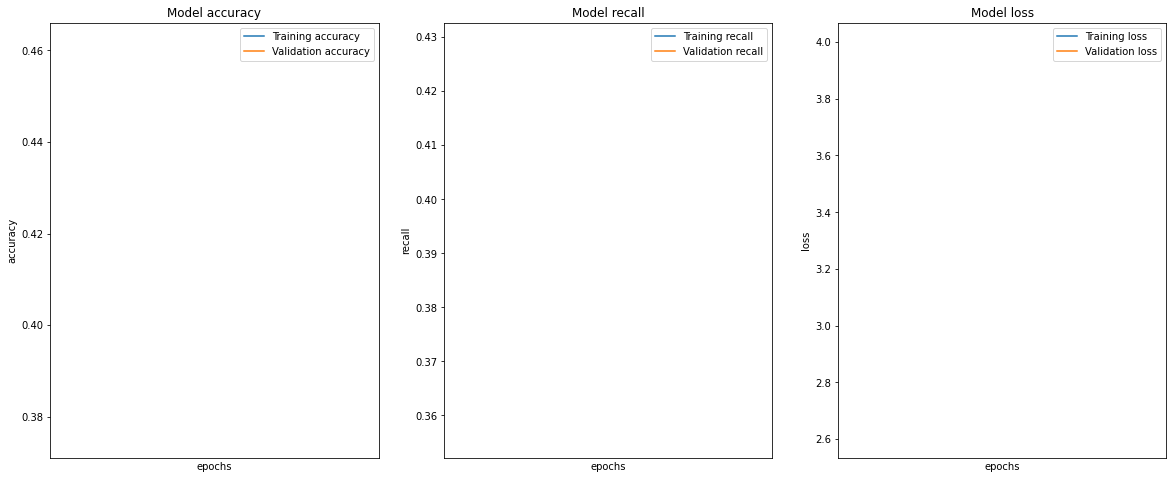

In [8]:
# VGG16

current_model     = VGG16
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'VGG16'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size, multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.vgg16.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.vgg16.preprocess_input)

# Training process
vgg16_model, vgg16_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                 val_multi_generator,
                                                                 multi_val_steps, 
                                                                 current_model,
                                                                 units,
                                                                 num_layers,
                                                                 dropout,
                                                                 globlayer,
                                                                 freeze_layers_num,
                                                                 model_name)
# Plot the training process
SkinCancerCnn.plot_model(vgg16_history, 'plots/default/VGG16_default_plot.jpg')

# Save the model
vgg16_model.save('./new_models/default/VGG16_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 53s 79ms/step - loss: 1.7346 - accuracy: 0.3375 - precision: 0.5526 - recall: 0.0965 - val_loss: 1.5663 - val_accuracy: 0.3935 - val_precision: 0.5562 - val_recall: 0.1406 - lr: 1.0000e-04


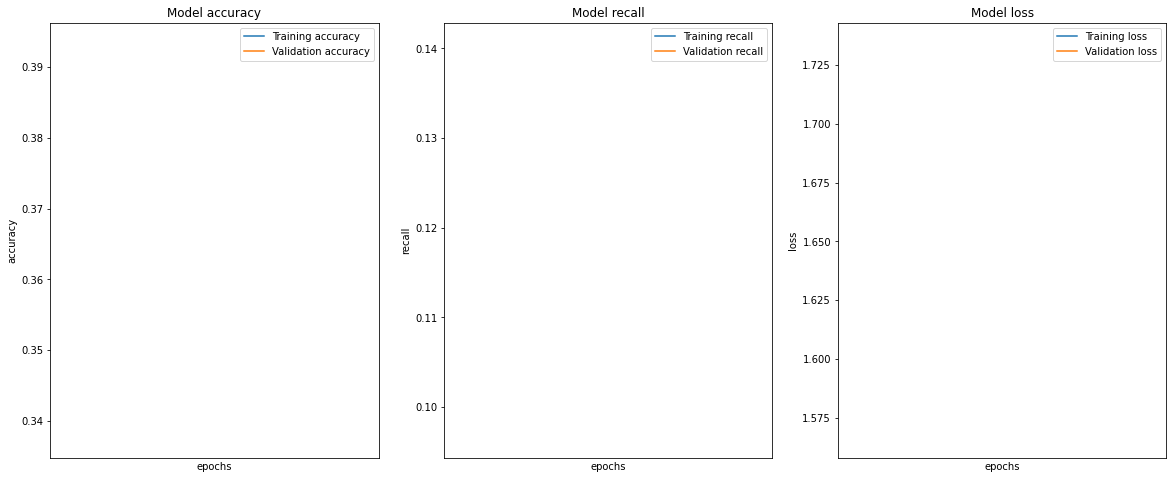

In [9]:
# InceptionV3
current_model     = InceptionV3
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'InceptionV3'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,  tf.keras.applications.inception_v3.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.inception_v3.preprocess_input)
# Training process
inceptionv3_model, inceptionv3_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                             val_multi_generator,
                                                                             multi_val_steps, 
                                                                             current_model,
                                                                             units,
                                                                             num_layers,
                                                                             dropout,
                                                                             globlayer,
                                                                             freeze_layers_num,
                                                                             model_name)
# Plot the training process
SkinCancerCnn.plot_model(inceptionv3_history, 'plots/default/InceptionV3_default_plot.jpg')

# Save the model
inceptionv3_model.save('./new_models/default/InceptionV3_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 53s 80ms/step - loss: 1.0534 - accuracy: 0.6250 - precision: 0.6980 - recall: 0.5404 - val_loss: 1.0747 - val_accuracy: 0.6264 - val_precision: 0.6557 - val_recall: 0.5653 - lr: 1.0000e-04


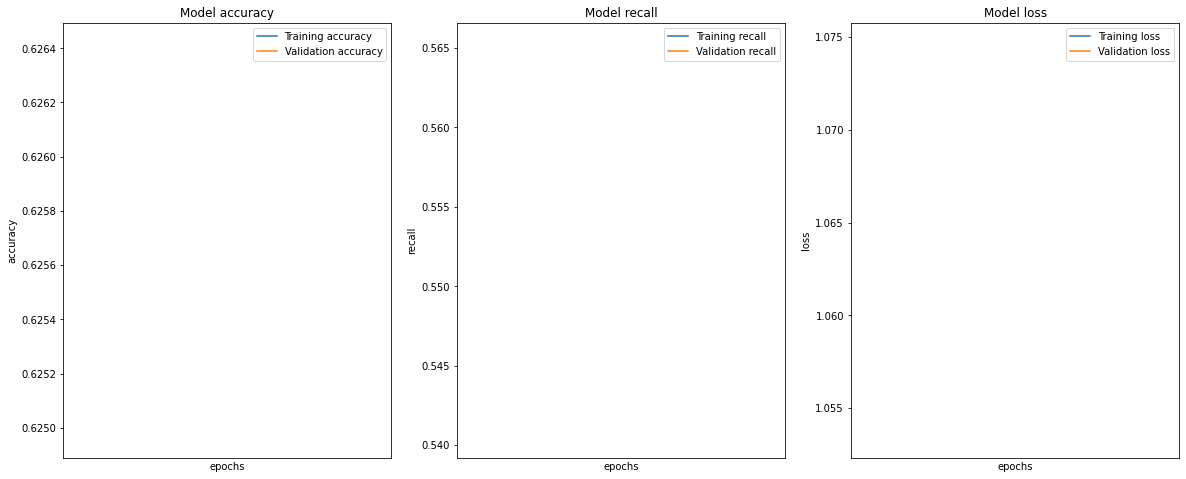

In [10]:
# ResNet50
current_model     = ResNet50
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'ResNet50'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.resnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.resnet.preprocess_input)

# Training process
resnet50_model, resnet50_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                       val_multi_generator,
                                                                       multi_val_steps, 
                                                                       current_model,
                                                                       units,
                                                                       num_layers,
                                                                       dropout,
                                                                       globlayer,
                                                                       freeze_layers_num,
                                                                       model_name)
# Plot the training process
SkinCancerCnn.plot_model(resnet50_history, 'plots/default/ResNet50_default_plot.jpg')

# Save the model
resnet50_model.save('./new_models/default/ResNet50_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 61s 87ms/step - loss: 1.1669 - accuracy: 0.5960 - precision: 0.6634 - recall: 0.5257 - val_loss: 1.0234 - val_accuracy: 0.6634 - val_precision: 0.7024 - val_recall: 0.6136 - lr: 1.0000e-04


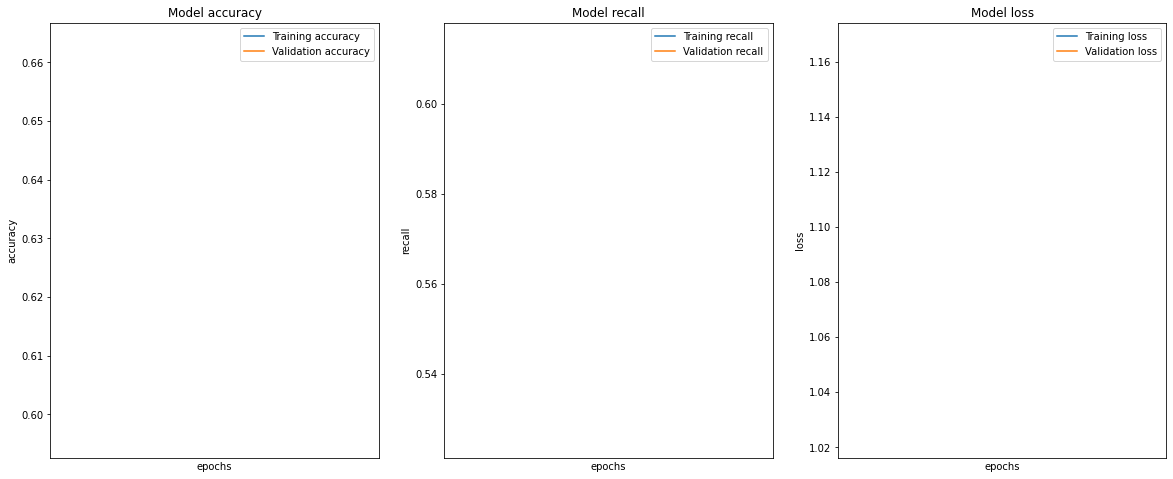

In [11]:
# ResNet152
current_model     = ResNet152
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'ResNet152'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size, 
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.resnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.resnet.preprocess_input)

# Training process
resnet152_model, resnet152_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                         val_multi_generator,
                                                                         multi_val_steps, 
                                                                         current_model,
                                                                         units,
                                                                         num_layers,
                                                                         dropout,
                                                                         globlayer,
                                                                         freeze_layers_num,
                                                                         model_name)
# Plot the training process
SkinCancerCnn.plot_model(resnet152_history, 'plots/default/ResNet152_default_plot.jpg')

# Save the model
resnet152_model.save('./new_models/default/ResNet152_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 64s 88ms/step - loss: 1.2531 - accuracy: 0.5465 - precision: 0.6555 - recall: 0.4110 - val_loss: 1.1707 - val_accuracy: 0.5682 - val_precision: 0.6574 - val_recall: 0.4361 - lr: 1.0000e-04


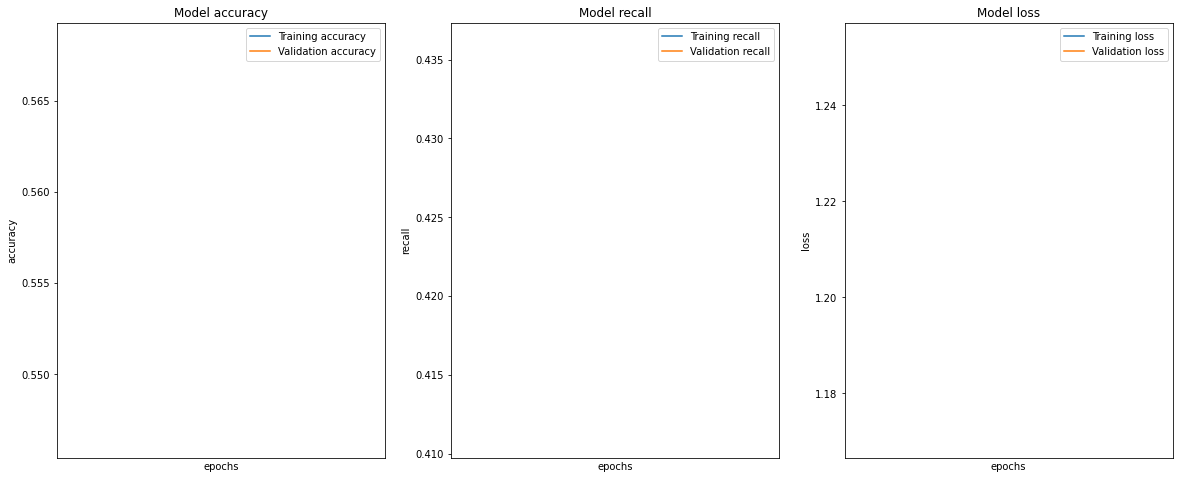

In [12]:
# DenseNet201
current_model     = DenseNet201
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'DenseNet201'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.densenet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.densenet.preprocess_input)

# Training process
densenet201_model, densenet201_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                             val_multi_generator,
                                                                             multi_val_steps, 
                                                                             current_model,
                                                                             units,
                                                                             num_layers,
                                                                             dropout,
                                                                             globlayer,
                                                                             freeze_layers_num,
                                                                             model_name)

# Plot the training process
SkinCancerCnn.plot_model(densenet201_history, 'plots/default/DenseNet201_default_plot.jpg')

# Save the model
densenet201_model.save('./new_models/default/DenseNet201_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 51s 78ms/step - loss: 1.3877 - accuracy: 0.5147 - precision: 0.6060 - recall: 0.4106 - val_loss: 1.0954 - val_accuracy: 0.6264 - val_precision: 0.6825 - val_recall: 0.5526 - lr: 1.0000e-04


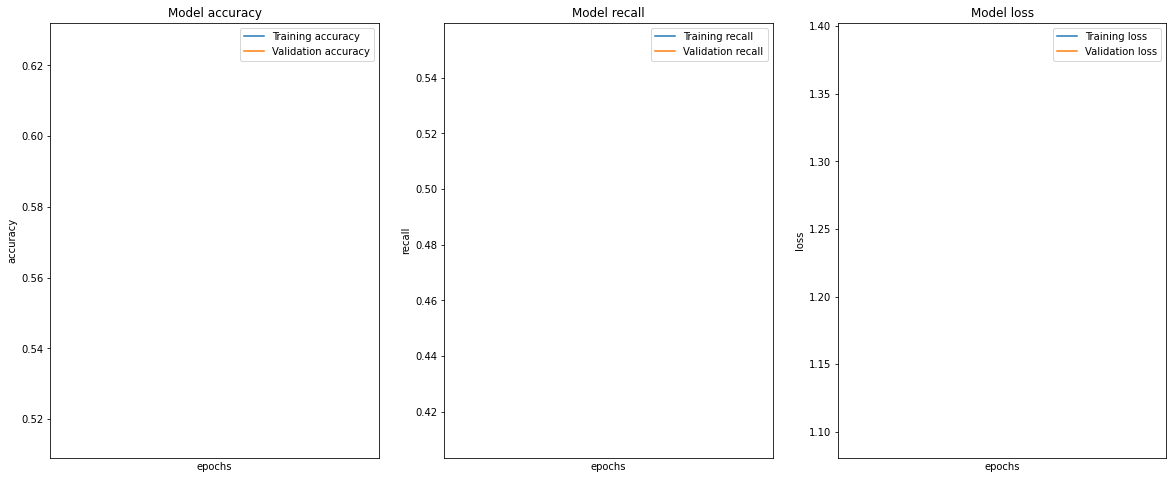

In [13]:
# MobileNetV2
current_model     = MobileNetV2
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'MobileNetV2'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.mobilenet_v2.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.mobilenet_v2.preprocess_input)

# Training process
mobilenetv2_model, mobilenetv2_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                             val_multi_generator,
                                                                             multi_val_steps, 
                                                                             current_model,
                                                                             units,
                                                                             num_layers,
                                                                             dropout,
                                                                             globlayer,
                                                                             freeze_layers_num,
                                                                             model_name)

# Plot the training process
SkinCancerCnn.plot_model(mobilenetv2_history, 'plots/default/MobileNetV2_default_plot.jpg')

# Save the model
mobilenetv2_model.save('./new_models/default/MobileNetV2_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 53s 78ms/step - loss: 1.2061 - accuracy: 0.5518 - precision: 0.7610 - recall: 0.2974 - val_loss: 1.0283 - val_accuracy: 0.6278 - val_precision: 0.7572 - val_recall: 0.4474 - lr: 1.0000e-04


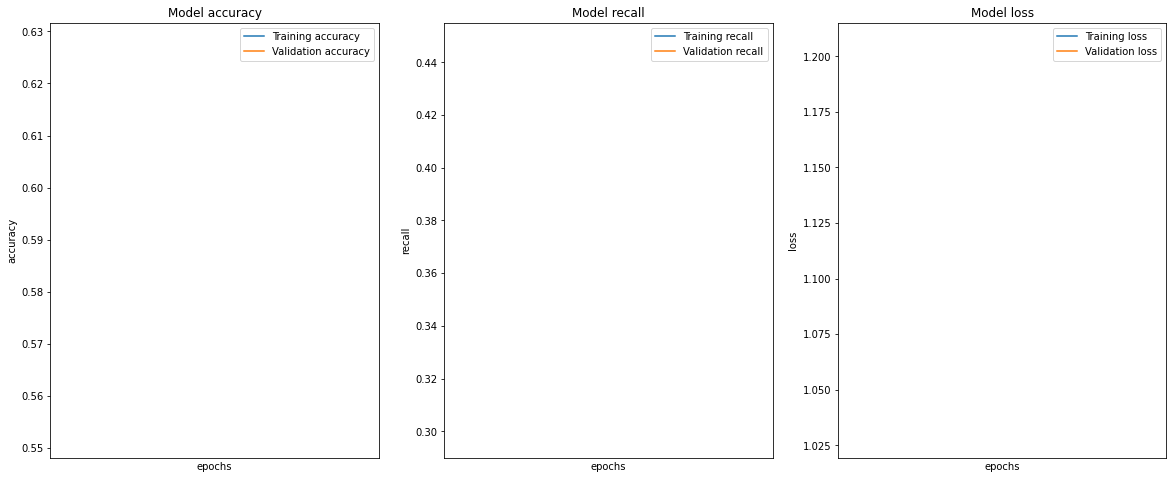

In [14]:
# EfficientNetB0
current_model     = EfficientNetB0
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'EfficientNetB0'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.efficientnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb0_model, efficientnetb0_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                             val_multi_generator,
                                                                             multi_val_steps, 
                                                                             current_model,
                                                                             units,
                                                                             num_layers,
                                                                             dropout,
                                                                             globlayer,
                                                                             freeze_layers_num,
                                                                             model_name)

# Plot the training process
SkinCancerCnn.plot_model(efficientnetb0_history, 'plots/default/EfficientNetB0_default_plot.jpg')

# Save the model
efficientnetb0_model.save('./new_models/default/EfficientNetB0_224x224_batch64_frezze_full_original_0.0001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 103s 143ms/step - loss: 1.4450 - accuracy: 0.4599 - precision: 0.7208 - recall: 0.1662 - val_loss: 1.5615 - val_accuracy: 0.3878 - val_precision: 0.4170 - val_recall: 0.1392 - lr: 1.0000e-04


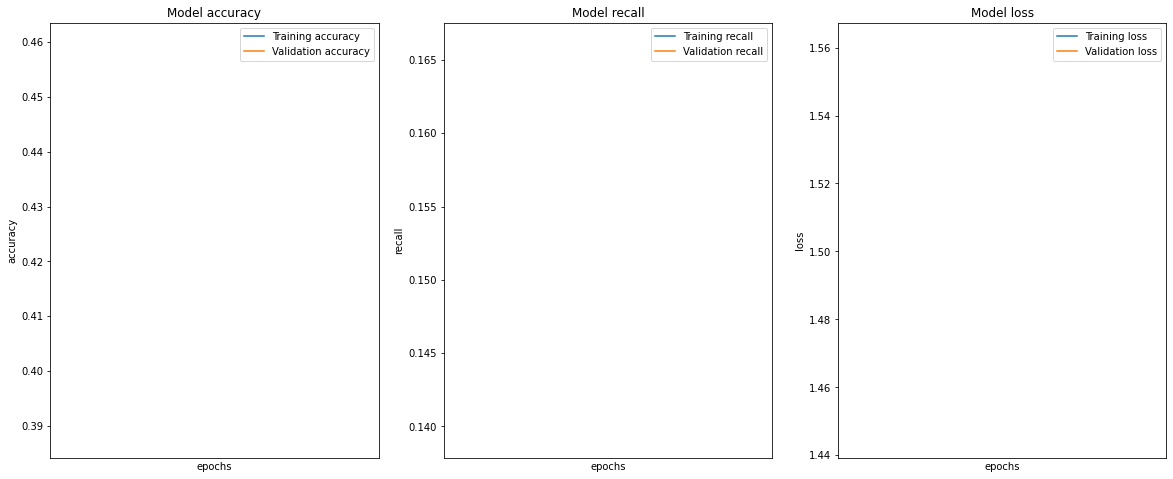

In [15]:
# EfficientNetB7
current_model     = EfficientNetB7
units             = 0
num_layers        = 0
dropout           = False
globlayer         = False
freeze_layers_num = 0
model_name        = 'EfficientNetB7'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0], 
                                                  multi_categories,
                                                  tf.keras.applications.efficientnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn.create_multiclass_generators(X_train,
                                                                                                       y_train,
                                                                                                       multiclass_directories[0],
                                                                                                       multiclass_directories[1],                                       
                                                                                                       multi_sizes,
                                                                                                       tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb7_model, efficientnetb7_history = my_skin_cnn.multi_class_model_train(train_multi_generator,
                                                                                   val_multi_generator,
                                                                                   multi_val_steps, 
                                                                                   current_model,
                                                                                   units,
                                                                                   num_layers,
                                                                                   dropout,
                                                                                   globlayer,
                                                                                   freeze_layers_num,
                                                                                   model_name)

# Plot the training process
SkinCancerCnn.plot_model(efficientnetb7_history, 'plots/default/EfficientNetB7_default_plot.jpg')

# Save the model
efficientnetb7_model.save('./new_models/default/EfficientNetB7_224x224_batch64_frezze_full_original_0.0001lr.h5')

### Optimized models training

In this section 8 different models have been trained with the following parameters:

|Model         |Number of new layers|Number of new neurons per layers| Dropout|Global average pooling|Number of frozen layers|
|--------------|--------------------|--------------------------------|--------|----------------------|-----------------------|
|VGG16         |1                   |512                             |False   |True                  |14                     |
|InceptionV3   |3                   |256                             |False   |True                  |50                     |
|ResNet50      |2                   |384                             |False   |False                 |90                     |
|ResNet152     |3                   |128                             |False   |False                 |200                    |
|DenseNet201   |2                   |384                             |True    |False                 |200                    |
|MobileNetV2   |1                   |256                             |False   |False                 |35                     |
|EfficientNetB0|3                   |384                             |False   |False                 |100                    |
|EfficientNetB7|3                   |128                             |True    |True                  |400                    |

The training process parameters are the followings:
 - Optimizer: Adam
 - Learning rate: 0.00001 initial
 - Batch size: 64
 - Max epochs number: 20
 - ReduceLROnPlateau with patience 2
 - EarlyStopping with patience 3

In [16]:
# Hyperparameters for training 
lr                = 0.00001
batch_size        = 64
img_size          = 75
epochs_num        = 1
reduce_lr         = True
early_stop        = True
my_skin_cnn_opt   = SkinCancerCnn(img_size, lr, batch_size, reduce_lr, early_stop, epochs_num)

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 49s 77ms/step - loss: 6.1801 - accuracy: 0.5446 - precision: 0.7069 - recall: 0.3849 - val_loss: 5.5519 - val_accuracy: 0.6648 - val_precision: 0.7467 - val_recall: 0.5653 - lr: 1.0000e-05


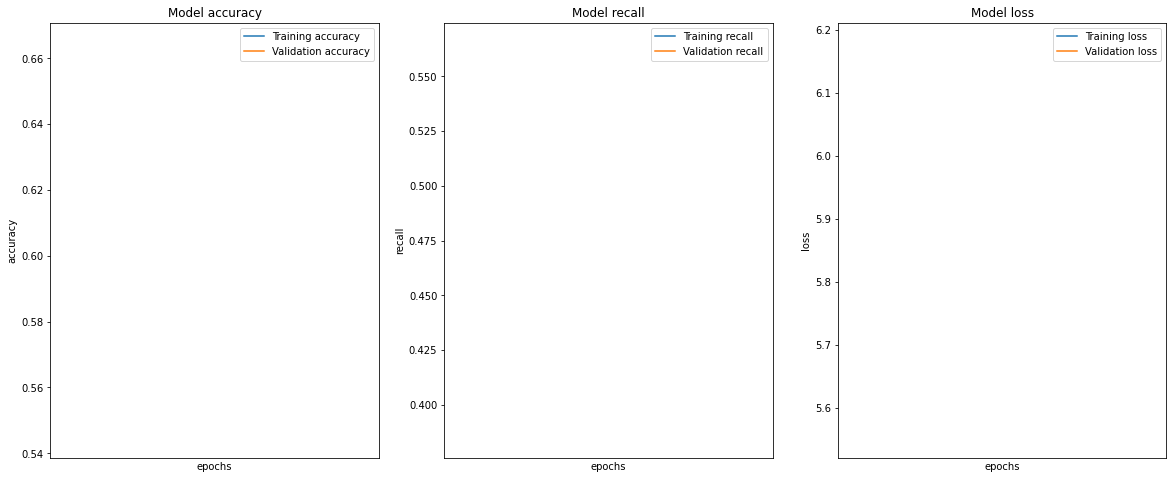

In [17]:
# VGG16 optimized 

current_model     = VGG16
units             = 512
num_layers        = 1
dropout           = False
globlayer         = True
freeze_layers_num = 14
model_name        = 'VGG16_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.vgg16.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.vgg16.preprocess_input)

# Training process
vgg16_optimized_model, vgg16_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                         val_multi_generator,
                                                                                         multi_val_steps, 
                                                                                         current_model,
                                                                                         units,
                                                                                         num_layers,
                                                                                         dropout,
                                                                                         globlayer,
                                                                                         freeze_layers_num,
                                                                                         model_name)

# Plot the training process
SkinCancerCnn.plot_model(vgg16_optimized_history, 'plots/optimized/VGG16_optimized_plot.jpg')

# Save the model
vgg16_optimized_model.save('./new_models/optimized/VGG16_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 59s 84ms/step - loss: 10.6787 - accuracy: 0.2897 - precision: 0.8318 - recall: 0.0510 - val_loss: 10.0176 - val_accuracy: 0.3906 - val_precision: 0.4722 - val_recall: 0.0241 - lr: 1.0000e-05


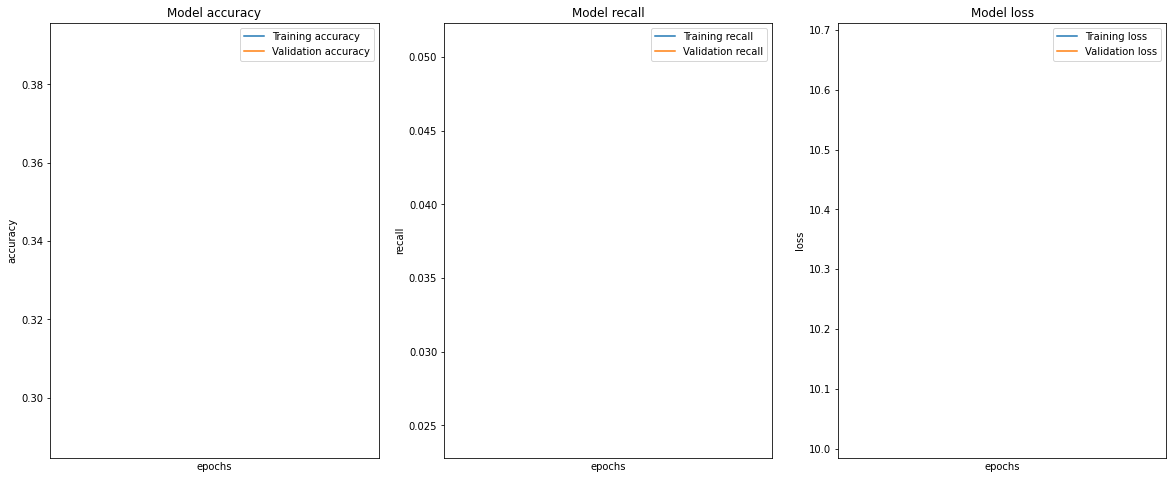

In [18]:
# InceptionV3 optimized

current_model     = InceptionV3
units             = 256
num_layers        = 3
dropout           = False
globlayer         = True
freeze_layers_num = 50
model_name        = 'InceptionV3_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.inception_v3.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.inception_v3.preprocess_input)

# Training process
inceptionv3_optimized_model, inceptionv3_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                                     val_multi_generator,
                                                                                                     multi_val_steps, 
                                                                                                     current_model,
                                                                                                     units,
                                                                                                     num_layers,
                                                                                                     dropout,
                                                                                                     globlayer,
                                                                                                     freeze_layers_num,
                                                                                                     model_name)

# Plot the training process
SkinCancerCnn.plot_model(inceptionv3_optimized_history, 'plots/optimized/InceptionV3_optimized_plot.jpg')

# Save the model
inceptionv3_optimized_model.save('./new_models/optimized/InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 56s 84ms/step - loss: 12.0376 - accuracy: 0.6105 - precision: 0.7534 - recall: 0.4676 - val_loss: 11.4879 - val_accuracy: 0.6562 - val_precision: 0.7220 - val_recall: 0.5866 - lr: 1.0000e-05


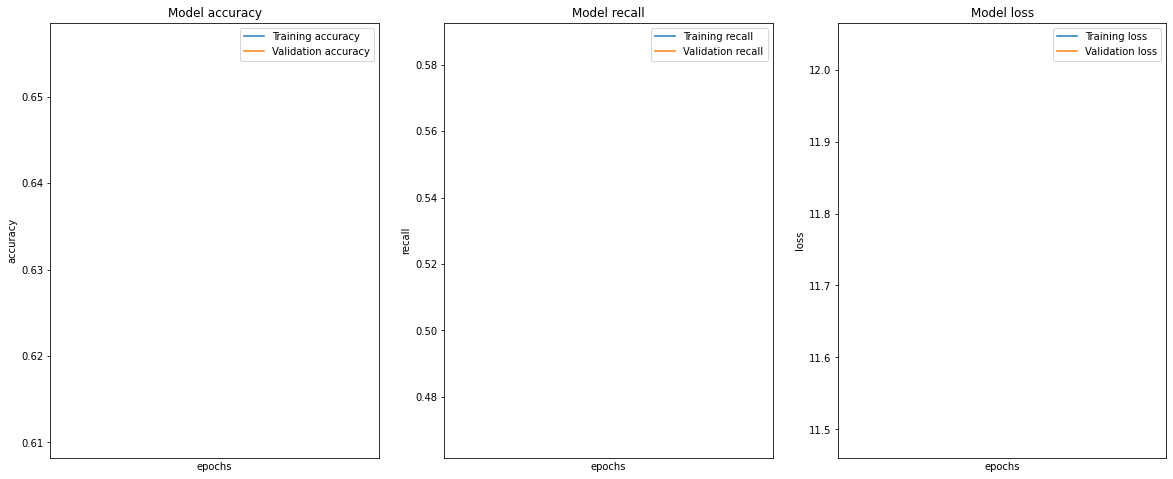

In [19]:
# ResNet50 optimized 

current_model     = ResNet50
units             = 384
num_layers        = 2
dropout           = False
globlayer         = False
freeze_layers_num = 90
model_name        = 'ResNet50_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.resnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.resnet.preprocess_input)

# Training process
resnet50_optimized_model, resnet50_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                               val_multi_generator,
                                                                                               multi_val_steps, 
                                                                                               current_model,
                                                                                               units,
                                                                                               num_layers,
                                                                                               dropout,
                                                                                               globlayer,
                                                                                               freeze_layers_num,
                                                                                               model_name)

# Plot the training process
SkinCancerCnn.plot_model(resnet50_optimized_history, 'plots/optimized/ResNet50_optimized_plot.jpg')

# Save the model
resnet50_optimized_model.save('./new_models/optimized/ResNet50_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 118s 174ms/step - loss: 6.0296 - accuracy: 0.5927 - precision: 0.7948 - recall: 0.4171 - val_loss: 5.6498 - val_accuracy: 0.6747 - val_precision: 0.7448 - val_recall: 0.6136 - lr: 1.0000e-05


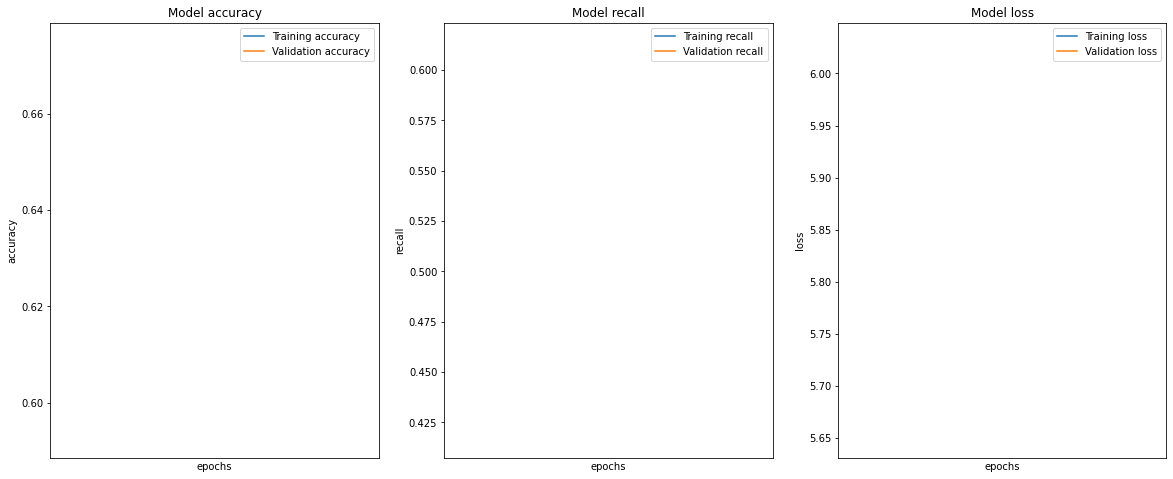

In [20]:
# ResNet152 optimized

current_model     = ResNet152
units             = 128
num_layers        = 3
dropout           = False
globlayer         = False
freeze_layers_num = 200
model_name        = 'ResNet152_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.resnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.resnet.preprocess_input)

# Training process
resnet152_optimized_model, resnet152_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                                 val_multi_generator,
                                                                                                 multi_val_steps, 
                                                                                                 current_model,
                                                                                                 units,
                                                                                                 num_layers,
                                                                                                 dropout,
                                                                                                 globlayer,
                                                                                                 freeze_layers_num,
                                                                                                 model_name)

# Plot the training process
SkinCancerCnn.plot_model(resnet152_optimized_history, 'plots/optimized/ResNet152_optimized_plot.jpg')

# Save the model
resnet152_optimized_model.save('./new_models/optimized/ResNet152_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 98s 135ms/step - loss: 11.5435 - accuracy: 0.3597 - precision: 0.6063 - recall: 0.1465 - val_loss: 9.8585 - val_accuracy: 0.6207 - val_precision: 0.8300 - val_recall: 0.4162 - lr: 1.0000e-05


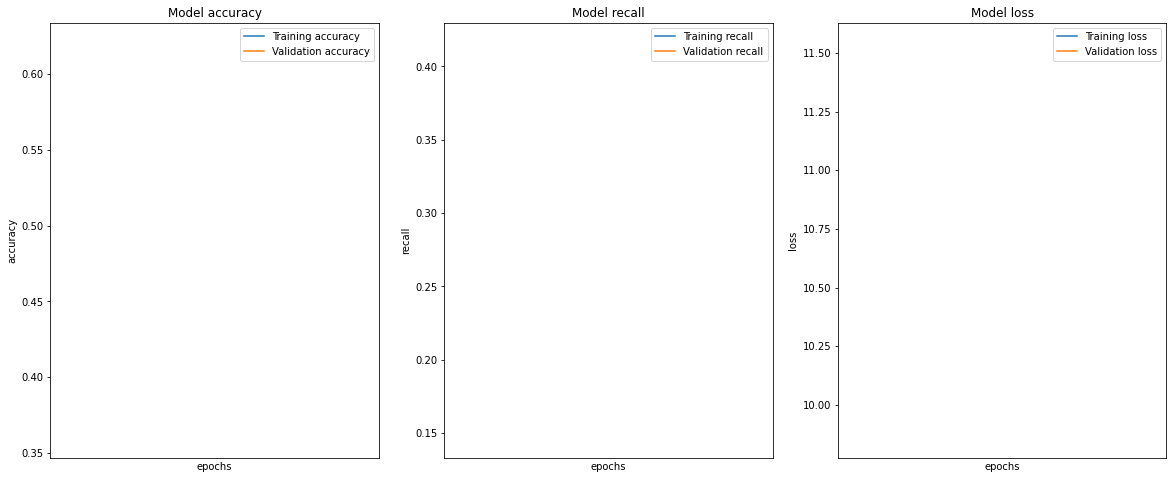

In [21]:
# DenseNet201 optimized

current_model     = DenseNet201
units             = 384
num_layers        = 2
dropout           = True
globlayer         = False
freeze_layers_num = 200
model_name        = 'DenseNet201_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories,
                                                  tf.keras.applications.densenet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.densenet.preprocess_input)

# Training process
densenet201_optimized_model, densenet201_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                                     val_multi_generator,
                                                                                                     multi_val_steps, 
                                                                                                     current_model,
                                                                                                     units,
                                                                                                     num_layers,
                                                                                                     dropout,
                                                                                                     globlayer,
                                                                                                     freeze_layers_num,
                                                                                                     model_name)

# Plot the training process
SkinCancerCnn.plot_model(densenet201_optimized_history, 'plots/optimized/DenseNet201_optimized_plot.jpg')

# Save the model
densenet201_optimized_model.save('./new_models/optimized/DenseNet201_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 56s 84ms/step - loss: 6.3927 - accuracy: 0.4500 - precision: 0.6114 - recall: 0.2739 - val_loss: 5.8251 - val_accuracy: 0.6506 - val_precision: 0.7568 - val_recall: 0.5526 - lr: 1.0000e-05


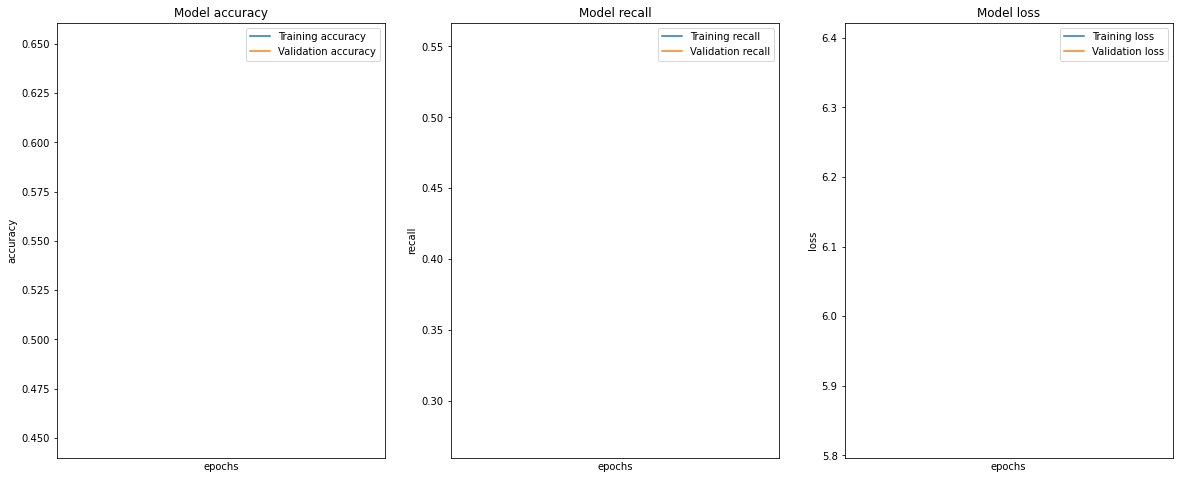

In [22]:
# MobileNetV2 optimized

current_model     = MobileNetV2
units             = 256
num_layers        = 1
dropout           = False
globlayer         = False
freeze_layers_num = 35
model_name        = 'MobileNetV2_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0], 
                                                  multi_categories,
                                                  tf.keras.applications.mobilenet_v2.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.mobilenet_v2.preprocess_input)

# Training process
mobilenetv2_optimized_model, mobilenetv2_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                                     val_multi_generator,
                                                                                                     multi_val_steps, 
                                                                                                     current_model,
                                                                                                     units,
                                                                                                     num_layers,
                                                                                                     dropout,
                                                                                                     globlayer,
                                                                                                     freeze_layers_num,
                                                                                                     model_name)

# Plot the training process
SkinCancerCnn.plot_model(mobilenetv2_optimized_history, 'plots/optimized/MobileNetV2_optimized_plot.jpg')

# Save the model
mobilenetv2_optimized_model.save('./new_models/optimized/MobileNetV2_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 56s 81ms/step - loss: 15.7282 - accuracy: 0.4351 - precision: 0.7645 - recall: 0.1425 - val_loss: 14.4842 - val_accuracy: 0.5994 - val_precision: 0.7481 - val_recall: 0.4176 - lr: 1.0000e-05


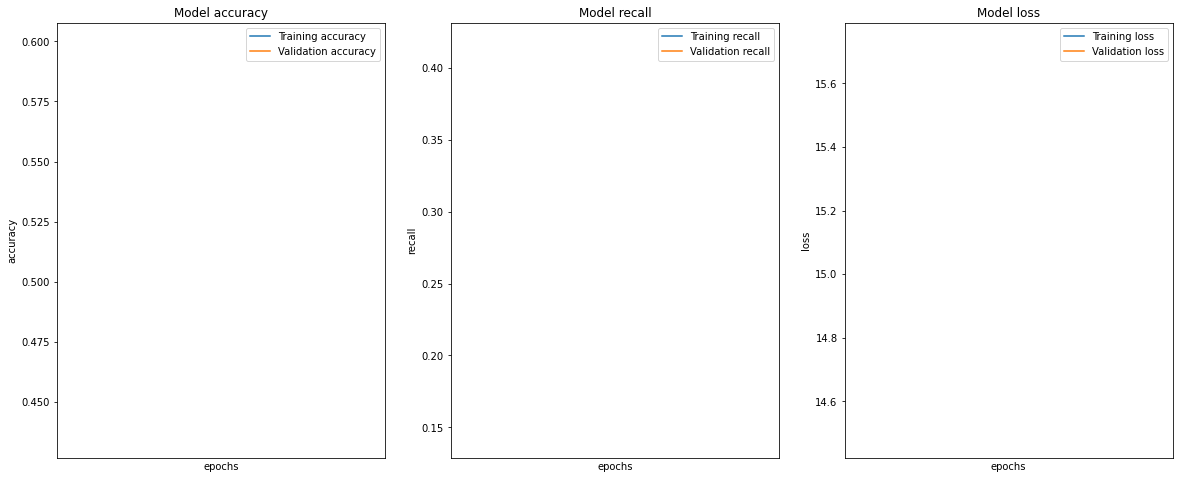

In [23]:
# EfficientNetB0 optimized

current_model     = EfficientNetB0
units             = 384
num_layers        = 3
dropout           = False
globlayer         = False
freeze_layers_num = 100
model_name        = 'EfficientNetB0_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size, 
                                                  multiclass_directories[0], 
                                                  multi_categories,
                                                  tf.keras.applications.efficientnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb0_optimized_model, efficientnetb0_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                                           val_multi_generator,
                                                                                                           multi_val_steps, 
                                                                                                           current_model,
                                                                                                           units,
                                                                                                           num_layers,
                                                                                                           dropout,
                                                                                                           globlayer,
                                                                                                           freeze_layers_num,
                                                                                                           model_name)

# Plot the training process
SkinCancerCnn.plot_model(efficientnetb0_optimized_history, 'plots/optimized/EfficientNetB0_optimized_plot.jpg')

# Save the model
efficientnetb0_optimized_model.save('./new_models/optimized/EfficientNetB0_optimized_224x224_batch64_0.00001lr.h5')

Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.
626/626 [==============================] - 202s 294ms/step - loss: 6.7138 - accuracy: 0.1809 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 6.3665 - val_accuracy: 0.5511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-05


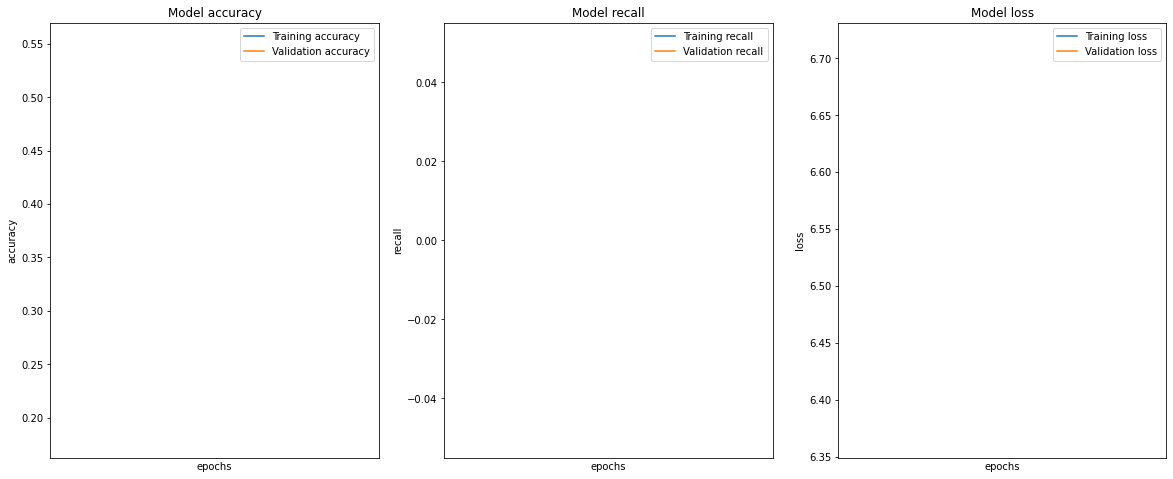

In [25]:
# EfficientNetB7 optimized

current_model     = EfficientNetB7
units             = 128
num_layers        = 3
dropout           = True
globlayer         = True
freeze_layers_num = 400
model_name        = 'EfficientNetB7_optimized'

# Create numpy array and generators for the model
X_train, y_train = SkinCancerCnn.create_image_arr(img_size, 
                                                  multiclass_directories[0], 
                                                  multi_categories,
                                                  tf.keras.applications.efficientnet.preprocess_input,
                                                  'train')

train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_opt.create_multiclass_generators(X_train,
                                                                                                           y_train,
                                                                                                           multiclass_directories[0],
                                                                                                           multiclass_directories[1],                                       
                                                                                                           multi_sizes,
                                                                                                           tf.keras.applications.efficientnet.preprocess_input)

# Training process
efficientnetb7_optimized_model, efficientnetb7_optimized_history = my_skin_cnn_opt.multi_class_model_train(train_multi_generator,
                                                                                                           val_multi_generator,
                                                                                                           multi_val_steps, 
                                                                                                           current_model,
                                                                                                           units,
                                                                                                           num_layers,
                                                                                                           dropout,
                                                                                                           globlayer,
                                                                                                           freeze_layers_num,
                                                                                                           model_name)

# Plot the training process
SkinCancerCnn.plot_model(efficientnetb7_optimized_history, 'plots/optimized/EfficientNetB7_optimized_plot.jpg')

# Save the model
efficientnetb7_optimized_model.save('./new_models/optimized/EfficientNetB7_optimized_224x224_batch64_0.00001lr.h5')

### Hyperparameter search

This section was used for Bayesian hyperparameter optimization. This is a long process because it tried different model configurations. On average it took about 15 hours/model.

In [7]:
# Hyperparameters for training 
lr                = 0.00001
batch_size        = 64
img_size          = 75
epochs_num        = 1
reduce_lr         = True
early_stop        = True
my_skin_cnn_hyper = SkinCancerCnn(img_size, lr, batch_size, reduce_lr, early_stop, epochs_num)


# Create numpy array and generators for Multiclass
X_train, y_train = SkinCancerCnn.create_image_arr(img_size,
                                                  multiclass_directories[0],
                                                  multi_categories, 
                                                  tf.keras.applications.efficientnet.preprocess_input, 
                                                  'train')

# Multi class NN
train_multi_generator, val_multi_generator, multi_val_steps = my_skin_cnn_hyper.create_multiclass_generators(X_train,
                                                                                                             y_train,
                                                                                                             multiclass_directories[0],
                                                                                                             multiclass_directories[1],                                       
                                                                                                             multi_sizes,
                                                                                                             tf.keras.applications.efficientnet.preprocess_input)


Image array done with shape: (8512, 75, 75, 3)
Found 751 images belonging to 7 classes.


In [8]:
def build_model(hp):
    
    current_model     = EfficientNetB0
    units             = hp.Int("units", min_value = 128, max_value = 512, step = 128)
    num_layers        = hp.Int("layers", min_value = 1, max_value = 3)
    dropout           = hp.Boolean("dropout")
    globlayer         = hp.Boolean("globlayer")
    freeze_layers_num = hp.Int("freeze_layers_num", min_value = 0, max_value = 200, step = 50)
    
    # call existing model-building code with the hyperparameter values.
    model = my_skin_cnn_hyper.multi_class_model(train_multi_generator,
                                                val_multi_generator,
                                                multi_val_steps,
                                                current_model,
                                                units,
                                                num_layers,
                                                dropout,
                                                globlayer,
                                                freeze_layers_num)

    return model

In [9]:
build_model(kt.HyperParameters())

In [10]:
tuner = kt.BayesianOptimization(build_model,
                                max_trials = 2, #TODO
                                # Do not resume the previous search in the same directory.
                                overwrite = True,
                                objective = kt.Objective("val_recall", direction=  "max"),
                                # Set a directory to store the intermediate results.
                                directory = "my_dir")


callbacks = []


decrease_lr = ReduceLROnPlateau(monitor   = 'val_recall',
                                factor    = 0.2,
                                min_lr    = 0.0000001,
                                patience  = 2,
                                verbose   = 1,
                                min_delta = 1e-6,
                                mode      = 'max')

early_stop = EarlyStopping(monitor              = 'val_recall',
                           min_delta            = 0,
                           patience             = 3,
                           verbose              = 0,
                           mode                 = 'max',
                           baseline             = None,
                           restore_best_weights = True)

callbacks.append(decrease_lr)
callbacks.append(early_stop)
callbacks.append(keras.callbacks.TensorBoard("loggings_bayes_efficientnetb0"))    

tuner.search(train_multi_generator,
             callbacks        = callbacks,
             epochs           = 2, #TODO
             validation_data  = val_multi_generator,
             validation_steps = multi_val_steps)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units is {best_hps.get('units')} 
and the optimal number of layers is {best_hps.get('layers')}
and the optimal use of dropout is {best_hps.get('dropout')}
and the optimal globlayer is {best_hps.get('globlayer')}
and the optimal freeze_layers_num is {best_hps.get('freeze_layers_num')}.
""")

Trial 2 Complete [00h 01m 40s]
val_recall: 0.11363636702299118

Best val_recall So Far: 0.39346590638160706
Total elapsed time: 00h 03m 44s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units is 384 
and the optimal number of layers is 2
and the optimal use of dropout is True
and the optimal globlayer is False
and the optimal freeze_layers_num is 100.



In [11]:
# Optimized hyperparameters for NN
lr                = 0.00001
batch_size        = 64
units             = best_hps.get('units')
num_layers        = best_hps.get('layers')         
dropout           = best_hps.get('dropout')
globlayer         = best_hps.get('globlayer')
freeze_layers_num = best_hps.get('freeze_layers_num')

# Save the hyperparameters
with open('./hyperparameters/hyperparameters_effnet.txt', 'w') as file:
    file.write('lr ' + str(lr) + '\n')
    file.write('batch_size ' + str(batch_size) + '\n')
    file.write('units ' + str(units) + '\n')
    file.write('num_layers ' + str(num_layers) + '\n')
    file.write('dropout ' + str(dropout) + '\n')
    file.write('globlayer ' + str(globlayer) + '\n')
    file.write('freeze_layers_num ' + str(freeze_layers_num) + '\n')

### Loading the default models

In this section, we are loading the trained default models for evaluation on the test set. We save the metrics scores, heatmaps with counter, and heatmaps with normalized values. The metrics we are interested in are the followings:
 - Accuracy
 - Precision
 - Recall / Balanced accuracy
 - F1-score
 - MCC
 - AVG
 
We save the ROC-AUC curve for the best model. 

In [26]:
img_size = 75

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.22      0.28      0.25        25
           1       0.22      0.36      0.28        36
           2       0.30      0.30      0.30        91
           3       0.07      0.50      0.13        10
           4       0.27      0.54      0.36        95
           5       0.89      0.50      0.64       486
           6       0.11      0.56      0.18         9

    accuracy                           0.46       752
   macro avg       0.30      0.43      0.30       752
weighted avg       0.67      0.46      0.52       752



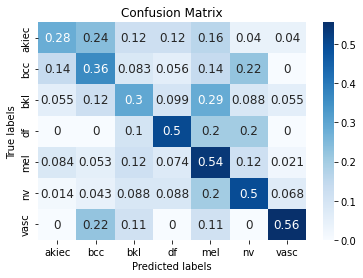

In [27]:
# VGG16
model_vgg16 = keras.models.load_model('./new_models/default/VGG16_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories, tf.keras.applications.vgg16.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_vgg16.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/VGG16_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/VGG16_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/VGG16_default_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.13      0.28      0.18        25
           1       0.17      0.42      0.24        36
           2       0.25      0.21      0.23        91
           3       0.05      0.40      0.10        10
           4       0.26      0.32      0.29        95
           5       0.90      0.48      0.62       486
           6       0.07      0.67      0.12         9

    accuracy                           0.42       752
   macro avg       0.26      0.40      0.25       752
weighted avg       0.66      0.42      0.49       752



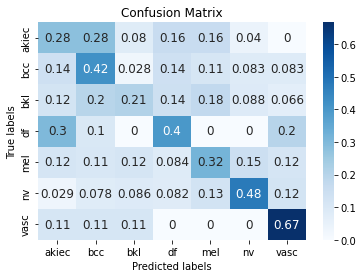

In [28]:
# InceptionV3
model_inceptionv3 = keras.models.load_model('./new_models/default/InceptionV3_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories, tf.keras.applications.inception_v3.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_inceptionv3.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/InceptionV3_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/InceptionV3_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/InceptionV3_default_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.38      0.40      0.39        25
           1       0.56      0.50      0.53        36
           2       0.33      0.65      0.44        91
           3       0.18      0.70      0.29        10
           4       0.41      0.63      0.50        95
           5       0.96      0.63      0.76       486
           6       0.70      0.78      0.74         9

    accuracy                           0.62       752
   macro avg       0.50      0.61      0.52       752
weighted avg       0.76      0.62      0.66       752



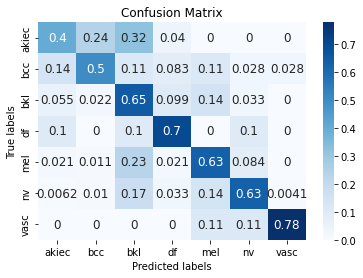

In [29]:
# ResNet50
model_resnet50 = keras.models.load_model('./new_models/default/ResNet50_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories, tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_p = model_resnet50.predict(X_test)
y_pred = [np.argmax(element) for element in y_p]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/ResNet50_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/ResNet50_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/ResNet50_default_heatmap_normalized.jpg')

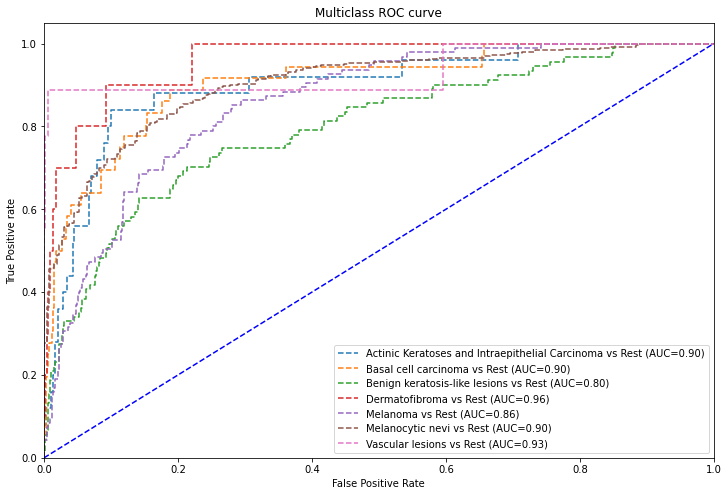

In [30]:
# ResNet50 ROC-AUC curve
SkinCancerCnn.plot_ROC_AUC_curve(y_true, y_p, 'ROC-AUC/default/ResNet50_default_ROC_AUC.jpg') 

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.30      0.56      0.39        25
           1       0.47      0.44      0.46        36
           2       0.38      0.51      0.44        91
           3       0.25      0.70      0.37        10
           4       0.41      0.55      0.47        95
           5       0.91      0.71      0.80       486
           6       0.42      0.89      0.57         9

    accuracy                           0.65       752
   macro avg       0.45      0.62      0.50       752
weighted avg       0.73      0.65      0.67       752



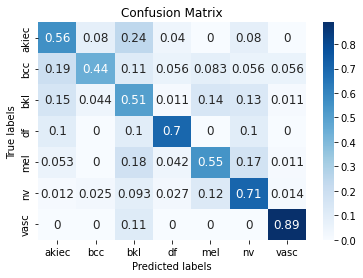

In [31]:
# ResNet152
model_resnet152 = keras.models.load_model('./new_models/default/ResNet152_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_resnet152.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/ResNet152_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/ResNet152_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/ResNet152_default_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.35      0.28      0.31        25
           1       0.44      0.61      0.51        36
           2       0.35      0.56      0.43        91
           3       0.11      0.60      0.19        10
           4       0.32      0.49      0.39        95
           5       0.95      0.63      0.75       486
           6       0.54      0.78      0.64         9

    accuracy                           0.59       752
   macro avg       0.44      0.56      0.46       752
weighted avg       0.74      0.59      0.63       752



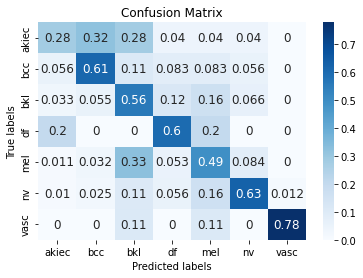

In [32]:
# DenseNet201
model_densenet201 = keras.models.load_model('./new_models/default/DenseNet201_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.densenet.preprocess_input, 'test') # create an image array with their corresponding labels for the test images
y_pred = model_densenet201.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/DenseNet201_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/DenseNet201_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/DenseNet201_default_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.28      0.20      0.23        25
           1       0.58      0.31      0.40        36
           2       0.33      0.68      0.44        91
           3       0.21      0.30      0.25        10
           4       0.32      0.24      0.27        95
           5       0.88      0.72      0.80       486
           6       0.15      0.67      0.24         9

    accuracy                           0.61       752
   macro avg       0.39      0.45      0.38       752
weighted avg       0.69      0.61      0.64       752



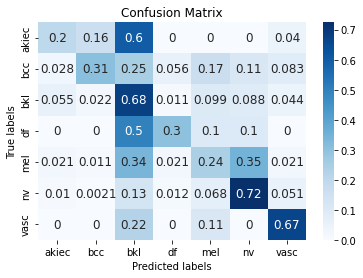

In [33]:
# MobileNetV2
model_mobilenetv2 = keras.models.load_model('./new_models/default/MobileNetV2_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.mobilenet_v2.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_mobilenetv2.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/MobileNetV2_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/MobileNetV2_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/MobileNetV2_default_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.30      0.36      0.33        25
           1       0.44      0.58      0.50        36
           2       0.34      0.52      0.41        91
           3       0.12      0.60      0.19        10
           4       0.41      0.42      0.42        95
           5       0.93      0.70      0.80       486
           6       0.30      0.78      0.44         9

    accuracy                           0.62       752
   macro avg       0.41      0.57      0.44       752
weighted avg       0.73      0.62      0.66       752



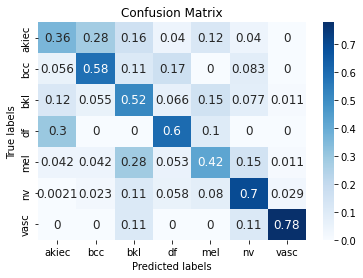

In [34]:
# EfficientNetB0
model_efficientnetb0 = keras.models.load_model('./new_models/default/EfficientNetB0_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_efficientnetb0.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/EfficientNetB0_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/EfficientNetB0_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/EfficientNetB0_default_heatmap_normalized.jpg')

In [ ]:
# EfficientNetB7
model_efficientnetb7 = keras.models.load_model('./new_models/default/EfficientNetB7_224x224_batch64_frezze_full_original_0.0001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_efficientnetb7.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/default/EfficientNetB7_default_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/default/EfficientNetB7_default_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/default/EfficientNetB7_default_heatmap_normalized.jpg')

### Loading the optimized models

The procedure in this section is the same as in the 'default' models case. 

In [35]:
img_size = 75

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.28      0.60      0.38        25
           1       0.47      0.44      0.46        36
           2       0.37      0.49      0.42        91
           3       0.27      0.70      0.39        10
           4       0.41      0.48      0.44        95
           5       0.93      0.75      0.83       486
           6       0.58      0.78      0.67         9

    accuracy                           0.66       752
   macro avg       0.47      0.61      0.51       752
weighted avg       0.74      0.66      0.69       752



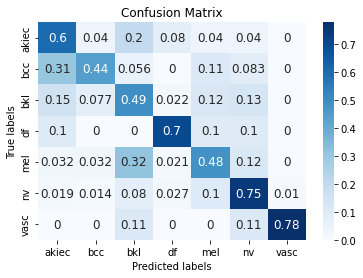

In [37]:
# VGG16_optimized
model_vgg16_optimized = keras.models.load_model('./new_models/optimized/VGG16_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.vgg16.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_vgg16_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/VGG16_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/VGG16_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/VGG16_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.18      0.52      0.27        25
           1       0.12      0.11      0.12        36
           2       0.22      0.23      0.22        91
           3       0.05      0.30      0.09        10
           4       0.19      0.42      0.27        95
           5       0.88      0.45      0.59       486
           6       0.18      0.78      0.29         9

    accuracy                           0.41       752
   macro avg       0.26      0.40      0.26       752
weighted avg       0.64      0.41      0.46       752



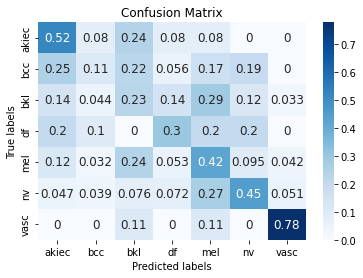

In [38]:
# InceptionV3_optimized
model_inceptionv3_optimized = keras.models.load_model('./new_models/optimized/InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.inception_v3.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_inceptionv3_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/InceptionV3_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/InceptionV3_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/InceptionV3_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.26      0.40      0.32        25
           1       0.51      0.58      0.55        36
           2       0.40      0.51      0.45        91
           3       0.18      0.50      0.26        10
           4       0.40      0.64      0.49        95
           5       0.94      0.71      0.81       486
           6       0.50      0.78      0.61         9

    accuracy                           0.66       752
   macro avg       0.46      0.59      0.50       752
weighted avg       0.75      0.66      0.69       752



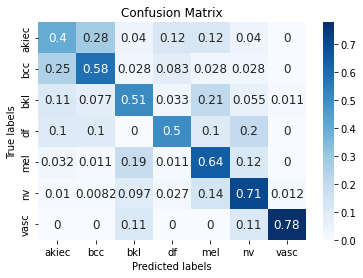

In [39]:
# ResNet50_optimized
model_resnet50_optimized = keras.models.load_model('./new_models/optimized/ResNet50_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_resnet50_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/ResNet50_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/ResNet50_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/ResNet50_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.38      0.44      0.41        25
           1       0.41      0.42      0.41        36
           2       0.41      0.64      0.50        91
           3       0.21      0.60      0.31        10
           4       0.41      0.57      0.48        95
           5       0.94      0.70      0.80       486
           6       0.35      0.89      0.50         9

    accuracy                           0.65       752
   macro avg       0.44      0.61      0.49       752
weighted avg       0.75      0.65      0.68       752



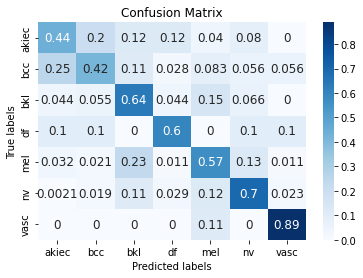

In [40]:
# ResNet152_optimized
model_resnet152_optimized = keras.models.load_model('./new_models/optimized/ResNet152_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_resnet152_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/ResNet152_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/ResNet152_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/ResNet152_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.29      0.48      0.36        25
           1       0.34      0.44      0.39        36
           2       0.33      0.33      0.33        91
           3       0.10      0.60      0.17        10
           4       0.31      0.41      0.36        95
           5       0.91      0.68      0.78       486
           6       0.35      0.89      0.50         9

    accuracy                           0.59       752
   macro avg       0.38      0.55      0.41       752
weighted avg       0.70      0.59      0.63       752



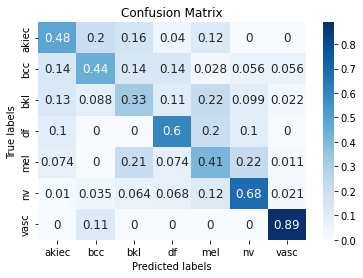

In [41]:
# DenseNet201_optimized
model_densenet201_optimized = keras.models.load_model('./new_models/optimized/DenseNet201_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.densenet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_densenet201_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/DenseNet201_optimizedmetrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/DenseNet201_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/DenseNet201_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.20      0.24      0.22        25
           1       0.32      0.64      0.43        36
           2       0.37      0.22      0.28        91
           3       0.09      0.30      0.13        10
           4       0.36      0.18      0.24        95
           5       0.81      0.81      0.81       486
           6       0.25      0.78      0.38         9

    accuracy                           0.62       752
   macro avg       0.34      0.45      0.35       752
weighted avg       0.64      0.62      0.62       752



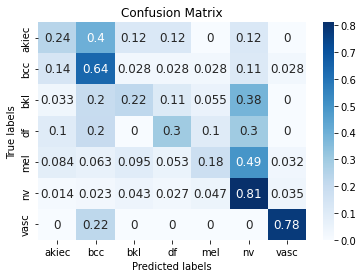

In [42]:
# MobileNetV2_optimized
model_mobilenetv2_optimized = keras.models.load_model('./new_models/optimized/MobileNetV2_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.mobilenet_v2.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_mobilenetv2_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/MobileNetV2_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/MobileNetV2_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/MobileNetV2_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.21      0.32      0.25        25
           1       0.33      0.42      0.37        36
           2       0.36      0.37      0.37        91
           3       0.09      0.60      0.16        10
           4       0.30      0.52      0.38        95
           5       0.94      0.62      0.74       486
           6       0.27      0.89      0.41         9

    accuracy                           0.56       752
   macro avg       0.36      0.53      0.38       752
weighted avg       0.72      0.56      0.61       752



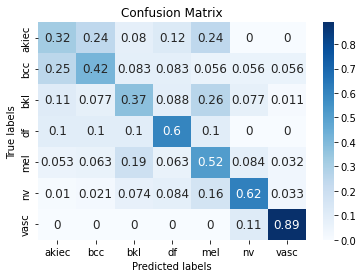

In [44]:
# EfficientNetB0_optimized
model_efficientnetb0_optimized = keras.models.load_model('./new_models/optimized/EfficientNetB0_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_pred = model_efficientnetb0_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_pred]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/EfficientNetB0_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/EfficientNetB0_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/EfficientNetB0_optimized_heatmap_normalized.jpg')

Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.17      0.44      0.25        25
           1       0.14      0.31      0.20        36
           2       0.17      0.02      0.04        91
           3       0.05      0.40      0.08        10
           4       0.30      0.08      0.13        95
           5       0.82      0.77      0.80       486
           6       0.11      0.33      0.16         9

    accuracy                           0.55       752
   macro avg       0.25      0.34      0.24       752
weighted avg       0.60      0.55      0.56       752



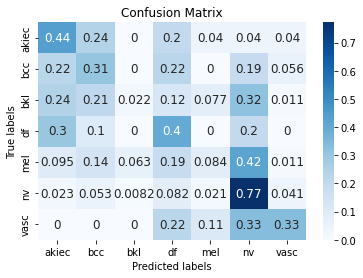

In [45]:
# EfficientNetB7_optimized
model_efficientnetb7_optimized = keras.models.load_model('./new_models/optimized/EfficientNetB7_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
y_p = model_efficientnetb7_optimized.predict(X_test)
y_pred = [np.argmax(element) for element in y_p]

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/optimized/EfficientNetB7_optimized_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, None, 'heatmaps/optimized/EfficientNetB7_optimized_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/optimized/EfficientNetB7_optimized_heatmap_normalized.jpg')

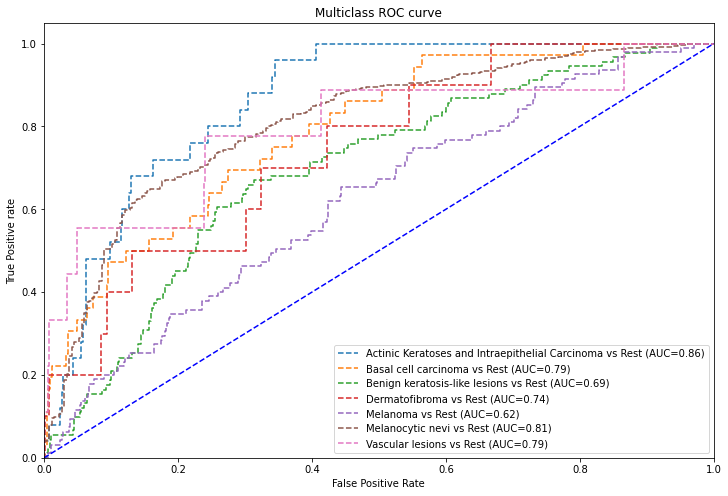

In [46]:
# EfficientNetB7_optimized ROC-AUC curve
SkinCancerCnn.plot_ROC_AUC_curve(y_true, y_p, 'ROC-AUC/optimized/EfficientNetB7_optimized_ROC_AUC.jpg') 

### Weighted average ensemble model

In this section, we took the 3 best models and use them for prediction. After the prediction phase we multiple that with the best weights for the ensemble predictions. In the last step, we save the metrics, confusion matrices, and ROC-AUC curve.

#### Grid search for optimal weights

In [7]:
# Grid search for weights

def best_weights_grid_search(preds):
    max_avg = 0.0 

    w1_opt = 0.0
    w2_opt = 0.0
    w3_opt = 0.0

    for w1 in range(0,9):
        for w2 in range(0,9):
            for w3 in range(0,9):

                wts                = [w1/10., w2/10., w3/10.]
                wted_preds1        = np.tensordot(preds, wts, axes=((0),(0)))
                wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
                accuracy           = accuracy_score(y_true, wted_ensemble_pred) # How many we got right
                recall             = recall_score(y_true, wted_ensemble_pred, average = 'macro') # Truth labels are the baseline, All class[i] truth how many we got right
                precision          = precision_score(y_true, wted_ensemble_pred, average = 'macro') # All class[i] predictions how many we got right
                f1_score           = 2 * (precision * recall) / (precision + recall)
                balanced_accuracy  = balanced_accuracy_score(y_true, wted_ensemble_pred)
                mcc                = matthews_corrcoef(y_true, wted_ensemble_pred)

                AVG = (balanced_accuracy + f1_score + mcc) / 3.0

                if AVG > max_avg:
                    max_avg = AVG
                    w1_opt = w1 / 10.0
                    w2_opt = w2 / 10.0
                    w3_opt = w3 / 10.0

    print('Best weights: ' + str(w1_opt) + ' ' + str(w2_opt) + ' ' + str(w3_opt) + ' with AVG: ' + str(max_avg)) 
    return [w1_opt, w2_opt, w3_opt]

Loading the three models and make predictions

In [8]:
img_size = 75

Image array done with shape: (752, 75, 75, 3)
Image array done with shape: (752, 75, 75, 3)
Image array done with shape: (752, 75, 75, 3)


c:\users\habon\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best weights: 0.7 0.1 0.0 with AVG: 0.5497686742356596
              precision    recall  f1-score   support

           0       0.33      0.52      0.40        25
           1       0.48      0.56      0.51        36
           2       0.43      0.44      0.44        91
           3       0.24      0.60      0.34        10
           4       0.44      0.58      0.50        95
           5       0.92      0.79      0.85       486
           6       0.54      0.78      0.64         9

    accuracy                           0.70       752
   macro avg       0.48      0.61      0.53       752
weighted avg       0.75      0.70      0.72       752



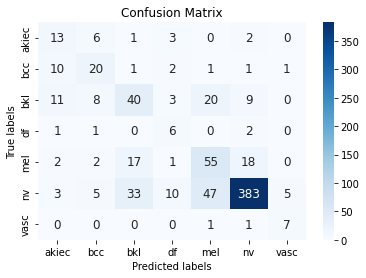

In [10]:
model_efficientnetb7_ensemble = keras.models.load_model('./new_models/optimized/EfficientNetB7_optimized_224x224_batch64_0.00001lr.h5')
model_resnet50_ensemble       = keras.models.load_model('./new_models/optimized/ResNet50_optimized_224x224_batch64_0.00001lr.h5')
model_inceptionv3_ensemble    = keras.models.load_model('./new_models/optimized/InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
X_test2,_      = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
X_test3,_      = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.inception_v3.preprocess_input,  'test') # create an image array with their corresponding labels for the test images


pred_efficientnet = model_efficientnetb7_ensemble.predict(X_test)
pred_resnet       = model_resnet50_ensemble.predict(X_test2)
pred_inception    = model_inceptionv3_ensemble.predict(X_test3)
preds = [pred_efficientnet, pred_resnet, pred_inception]
preds = np.array(preds)

# Weighted
#weights = [0.5, 0.7, 0.4]
weights = best_weights_grid_search(preds)

# Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

# Metrics, confusion matrix, normalized confusion matrix
SkinCancerCnn.metrics_scores(y_true, weighted_ensemble_prediction, 'metrics/ensemble/ensemble_metrics.txt')
SkinCancerCnn.confusion_matrix(y_true, weighted_ensemble_prediction, 'true', 'heatmaps/ensemble/ensemble_heatmap.jpg')
SkinCancerCnn.confusion_matrix(y_true, weighted_ensemble_prediction, None, 'heatmaps/ensemble/ensemble_heatmap_normalized.jpg')

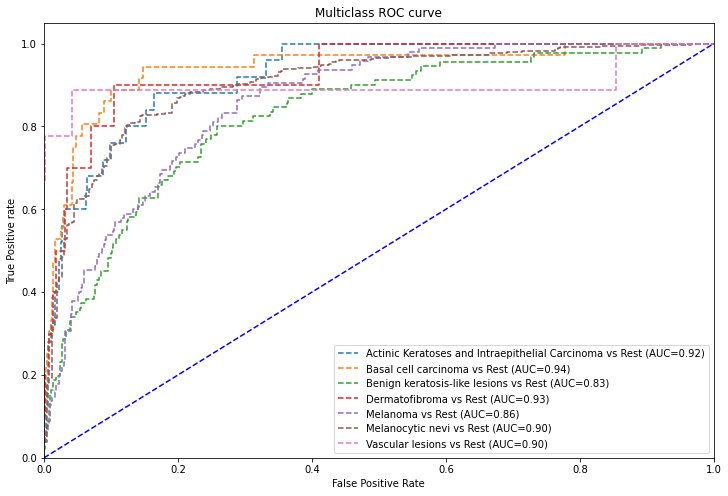

In [11]:
# ROC-AUC curve
SkinCancerCnn.plot_ROC_AUC_curve(y_true, weighted_preds, 'ROC-AUC/ensemble/ensemble_ROC_AUC.jpg') 

### Plots for metrics

In this section, I created the plots for the default, optimized, and the ensemble model. I created one plot for the accuracies and one for the AVG metrics.

In [20]:
def metrics_visualization(models, values, fname, red):

    plt.rcParams["figure.figsize"] = (13,7)

    x  = np.arange(len(models))
    y  = values

    width   = 0.7
    fig, ax = plt.subplots()

    if red:
        pps = ax.bar(x, y, width, align='center', color = (0.8, 0.1, 0.1, 0.8))
    else:
        pps = ax.bar(x, y, width, align='center')
        
    plt.xticks(x, models)

    for p in pps:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height - 9,
          s="{}%".format(height),
          ha='center', fontsize=14, color = 'white')

    plt.show()
    fig.savefig(fname)


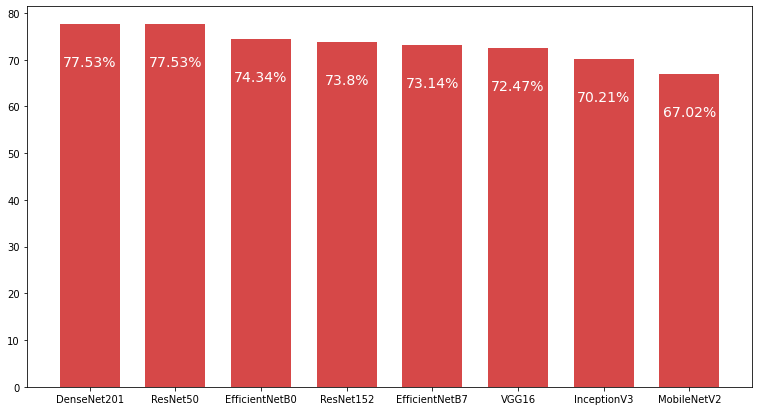

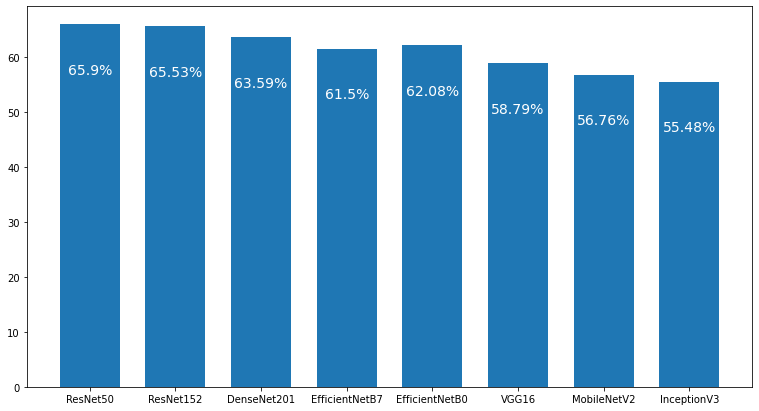

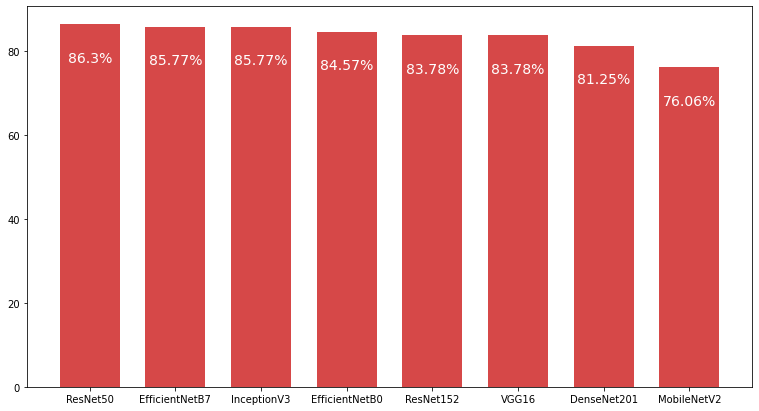

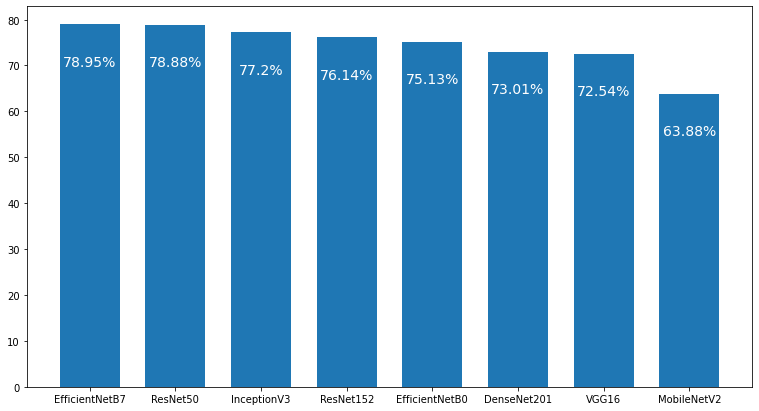

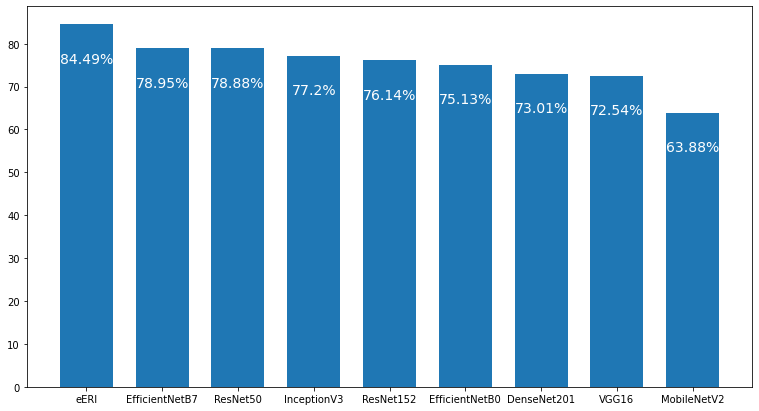

In [22]:
models_default_acc = ['DenseNet201', 'ResNet50', 'EfficientNetB0', 'ResNet152', 'EfficientNetB7', 'VGG16', 'InceptionV3', 'MobileNetV2']
default_acc        = [77.53, 77.53, 74.34, 73.80, 73.14, 72.47, 70.21, 67.02]
models_default_avg = ['ResNet50', 'ResNet152', 'DenseNet201', 'EfficientNetB7', 'EfficientNetB0', 'VGG16', 'MobileNetV2', 'InceptionV3']
default_avg        = [65.90, 65.53, 63.59, 61.50, 62.08, 58.79, 56.76, 55.48]

models_optimized_acc = ['ResNet50', 'EfficientNetB7',  'InceptionV3', 'EfficientNetB0', 'ResNet152', 'VGG16','DenseNet201', 'MobileNetV2']
optimized_acc        = [86.30, 85.77, 85.77, 84.57, 83.78, 83.78, 81.25, 76.06]
models_optimized_avg = ['EfficientNetB7', 'ResNet50', 'InceptionV3', 'ResNet152', 'EfficientNetB0', 'DenseNet201', 'VGG16', 'MobileNetV2']
optimized_avg        = [78.95, 78.88, 77.20, 76.14, 75.13, 73.01, 72.54, 63.88]

models_ensemble_avg = ['eERI', 'EfficientNetB7', 'ResNet50', 'InceptionV3', 'ResNet152', 'EfficientNetB0', 'DenseNet201', 'VGG16', 'MobileNetV2']
ensemble_avg        = [84.49, 78.95, 78.88, 77.20, 76.14, 75.13, 73.01, 72.54, 63.88]

metrics_visualization(models_default_acc, default_acc, 'metrics_visualization/default/default_acc.jpg', True)
metrics_visualization(models_default_avg, default_avg, 'metrics_visualization/default/default_avg.jpg', False)
metrics_visualization(models_optimized_acc, optimized_acc, 'metrics_visualization/optimized/optimized_acc.jpg', True)
metrics_visualization(models_optimized_avg, optimized_avg, 'metrics_visualization/optimized/optimized_avg.jpg', False)
metrics_visualization(models_ensemble_avg, ensemble_avg, 'metrics_visualization/ensemble/ensemble_avg.jpg', False)

### Gaussian and Poisson noise

In [24]:
img_size = 75

I created new folders (new test set) for the Poisson and Gaussian noise images. After that, I tested the best 'eERI' model with these images. 

In [25]:
def create_perturbated_folders(path, mode):

    directories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 
    images_path = []

    for directory in directories:
        for img in os.listdir(path + '/' + directory):
            images_path.append(os.path.join(path,directory,img))


    for img_path in images_path:
        img = skimage.io.imread(img_path)
        gimg = skimage.util.random_noise(img, mode=mode)
        skimage.io.imsave(img_path, gimg)

These folders are already there!

In [26]:
'''poisson_path  = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Poisson test set'
gaussian_path = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Gaussian test set'

create_perturbated_folders(poisson_path, 'poisson')
create_perturbated_folders(gaussian_path, 'gaussian')'''

"poisson_path  = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Poisson test set'\ngaussian_path = 'D:\\MSC_szakdolgozat\\MSC_szakdoga\\Datas\\Multiclass\\Gaussian test set'\n\ncreate_perturbated_folders(poisson_path, 'poisson')\ncreate_perturbated_folders(gaussian_path, 'gaussian')"

In [32]:
def adversarial_black_box_perturbation(path, perturbation, mode):

    model_efficientnetb7 = keras.models.load_model('./new_models/optimized/EfficientNetB7_optimized_224x224_batch64_0.00001lr.h5')
    model_resnet50       = keras.models.load_model('./new_models/optimized/ResNet50_optimized_224x224_batch64_0.00001lr.h5')
    model_inceptionv3    = keras.models.load_model('./new_models/optimized/InceptionV3_optimized_224x224_batch64_0.00001lr.h5')

    multi_test = './Datas/Multiclass/' + path

    X_test, y_true = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.efficientnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
    X_test2,_      = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.resnet.preprocess_input,  'test') # create an image array with their corresponding labels for the test images
    X_test3,_      = SkinCancerCnn.create_image_arr(img_size, multi_test, multi_categories,  tf.keras.applications.inception_v3.preprocess_input,  'test') # create an image array with their corresponding labels for the test images

    pred_efficientnet = model_efficientnetb7.predict(X_test)
    pred_resnet       = model_resnet50.predict(X_test2)
    pred_inception    = model_inceptionv3.predict(X_test3)
    preds = [pred_efficientnet, pred_resnet, pred_inception]
    preds = np.array(preds)

    #weighted average
    weights = [0.5, 0.7, 0.4]

    #Use tensordot to sum the products of all elements over specified axes.
    weighted_preds               = np.tensordot(preds, weights, axes=((0),(0)))
    weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

    SkinCancerCnn.metrics_scores(y_true, weighted_ensemble_prediction, 'metrics/' + mode + '/' + perturbation + '.txt')
    SkinCancerCnn.confusion_matrix(y_true, weighted_ensemble_prediction, 'true', 'heatmaps/perturbation/' + perturbation + '.jpg')

Image array done with shape: (752, 75, 75, 3)
Image array done with shape: (752, 75, 75, 3)
Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.39      0.44      0.42        25
           1       0.51      0.53      0.52        36
           2       0.46      0.45      0.45        91
           3       0.17      0.70      0.28        10
           4       0.36      0.63      0.46        95
           5       0.93      0.72      0.81       486
           6       0.44      0.78      0.56         9

    accuracy                           0.66       752
   macro avg       0.47      0.61      0.50       752
weighted avg       0.75      0.66      0.69       752



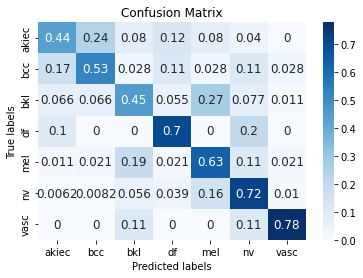

In [33]:
adversarial_black_box_perturbation('Poisson test set', 'Possion_perturbation_eERI', 'poisson')

Image array done with shape: (752, 75, 75, 3)
Image array done with shape: (752, 75, 75, 3)
Image array done with shape: (752, 75, 75, 3)
              precision    recall  f1-score   support

           0       0.26      0.40      0.32        25
           1       0.43      0.42      0.42        36
           2       0.38      0.44      0.41        91
           3       0.09      0.30      0.14        10
           4       0.32      0.67      0.44        95
           5       0.93      0.62      0.75       486
           6       0.40      0.89      0.55         9

    accuracy                           0.59       752
   macro avg       0.40      0.53      0.43       752
weighted avg       0.73      0.59      0.63       752



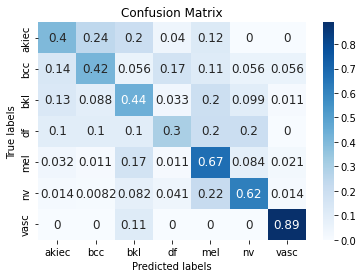

In [34]:
adversarial_black_box_perturbation('Gaussian test set', 'Gaussian_perturbation_eERI', 'gauss')

This code section was used for CNN confidence level check with Poisson and Gaussian noise images.

In [36]:
def confidence_visualization(model_origin, model_poisson, model_gauss, fname):
    
    plt.rcParams["figure.figsize"] = (12,8)
    labels = [ 'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    x       = np.arange(len(labels))  # the label locations
    width   = 0.28  # the width of the bars
    fig, ax = plt.subplots()

    bar1 = ax.bar(x, model_origin, width, color = 'r', label = 'eERI')
    bar2 = ax.bar(x+width, model_poisson, width, color='g', label = 'eERI Poisson')
    bar3 = ax.bar(x+width*2, model_gauss, width, color = 'b', label = 'eERI Gaussian')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(bar1, padding=3)
    ax.bar_label(bar2, padding=3)
    ax.bar_label(bar3, padding=3)

    fig.tight_layout()
    fig.savefig(fname)


    plt.show()

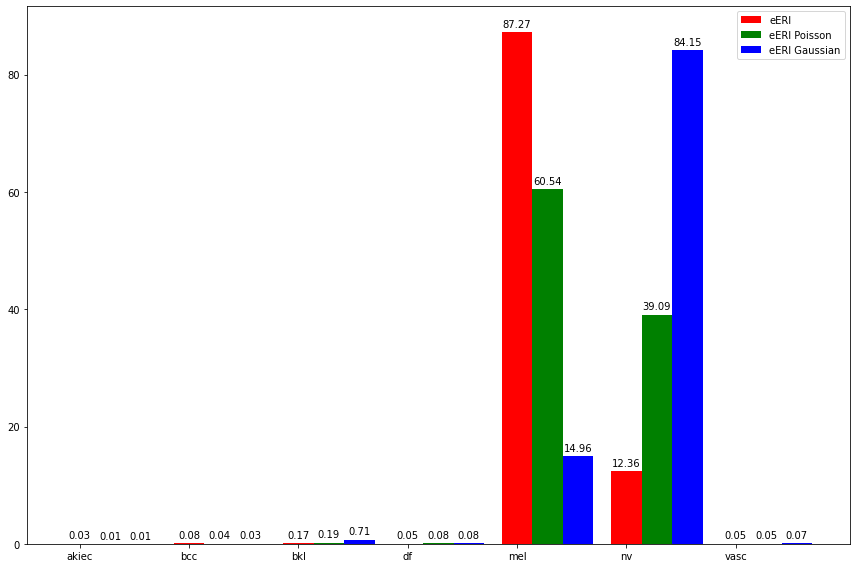

In [38]:
# This values were the confidence levels for the given images (for more information see the .pdf file)
model_origin  = [0.03, 0.08, 0.17, 0.05, 87.27, 12.36, 0.05]
model_poisson = [0.01, 0.04, 0.19, 0.08, 60.54, 39.09, 0.05]
model_gauss   = [0.01, 0.03, 0.71, 0.08, 14.96, 84.15, 0.07]

confidence_visualization(model_origin, model_poisson, model_gauss, 'confidence.jpg')

### FGSM white box untargeted attack

I tested the optimized EfficientNetB7 and ResNet50 models with white box untargeted FGSM attacks.

In [12]:
model_efficientnetb7 = keras.models.load_model('./new_models/optimized/EfficientNetB7_optimized_224x224_batch64_0.00001lr.h5')
model_resnet50       = keras.models.load_model('./new_models/optimized/ResNet50_optimized_224x224_batch64_0.00001lr.h5')

#### Helper functions for FGSM

In [13]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def preprocess(image, preprocess, img_size):
    
    image = tf.image.resize(image, (img_size, img_size))
    image = preprocess(image)
    image = image[None, ...]
    return image

def create_adversarial_pattern(input_image, input_label, model):
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

def mapping_labels(index):
    
    labels_dict={
      0: 'akiec', 
      1: 'bcc', 
      2: 'bkl', 
      3: 'df', 
      4: 'mel',
      5: 'nv', 
      6: 'vasc' 
    } 
    
    return labels_dict[index]

def mapping_indices(index):
    
    labels_dict={
      'akiec' : 0, 
      'bcc': 1, 
      'bkl': 2, 
      'df': 3, 
      'mel': 4, 
      'nv': 5, 
      'vasc': 6 
    } 
    
    return labels_dict[index]

def display_images(image, model):
    
    predictions = model.predict(image)
    label = np.argmax(predictions, axis = 1)
    confidence = float(max((model.predict(image))[0]))
    #plt.figure()
    #plt.imshow(image[0]  / 255.0) #*0.5+0.5
    #plt.imshow(image[0] *0.5+0.5) #*0.5+0.5
    #print(label)
    #plt.title('\n {} : {:.2f}% Confidence'.format(mapping_labels(label[0]), confidence*100))
    #plt.show()
    return label

Reading images from the original Test set, and adding perturbation for the images one by one iteratively

In [16]:
def FGSM(img_size, model, prep, epsilons):

    path        = './Datas/Multiclass/Test set'
    directories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 
    y_true      = []
    y_pred      = []
    ind         = 0

    for directory in directories:
        for img in os.listdir(path + '/' + directory):

            img_path  = os.path.join(path,directory,img)
            image_raw = tf.io.read_file(img_path)
            image     = tf.image.decode_image(image_raw)

            image       = preprocess(image, prep, img_size)
            image_probs = model.predict(image)
            label       = np.argmax(image_probs, axis = 1)

            skin_index = mapping_indices(directory)
            y_true.append(skin_index)

            label      = tf.one_hot(skin_index, image_probs.shape[-1])
            label      = tf.reshape(label, (1, image_probs.shape[-1]))

            perturbations = create_adversarial_pattern(image, label, model)

            epsilons = epsilons

            for i, eps in enumerate(epsilons):
                adv_x = image + eps*perturbations            
                pred_label = display_images(adv_x, model)
                y_pred.append(pred_label[0])
            ind += 1
            print('The current image is: ' + str(ind))
            
    return y_true, y_pred


In [ ]:
#y_true, y_pred = FGSM(75, model_efficientnetb7, tf.keras.applications.efficientnet.preprocess_input, [0.1])

In [ ]:
#y_true, y_pred = FGSM(75, model_efficientnetb7, tf.keras.applications.efficientnet.preprocess_input, [0.3])

In [ ]:
#y_true, y_pred = FGSM(75, model_efficientnetb7, tf.keras.applications.efficientnet.preprocess_input, [0.5])

In [17]:
y_true, y_pred = FGSM(75, model_resnet50, tf.keras.applications.resnet.preprocess_input, [0.5])

The current image is: 1
The current image is: 2
The current image is: 3
The current image is: 4
The current image is: 5
The current image is: 6
The current image is: 7
The current image is: 8
The current image is: 9
The current image is: 10
The current image is: 11
The current image is: 12
The current image is: 13
The current image is: 14
The current image is: 15
The current image is: 16
The current image is: 17
The current image is: 18
The current image is: 19
The current image is: 20
The current image is: 21
The current image is: 22
The current image is: 23
The current image is: 24
The current image is: 25
The current image is: 26
The current image is: 27
The current image is: 28
The current image is: 29
The current image is: 30
The current image is: 31
The current image is: 32
The current image is: 33
The current image is: 34
The current image is: 35
The current image is: 36
The current image is: 37
The current image is: 38
The current image is: 39
The current image is: 40
The curre

The current image is: 321
The current image is: 322
The current image is: 323
The current image is: 324
The current image is: 325
The current image is: 326
The current image is: 327
The current image is: 328
The current image is: 329
The current image is: 330
The current image is: 331
The current image is: 332
The current image is: 333
The current image is: 334
The current image is: 335
The current image is: 336
The current image is: 337
The current image is: 338
The current image is: 339
The current image is: 340
The current image is: 341
The current image is: 342
The current image is: 343
The current image is: 344
The current image is: 345
The current image is: 346
The current image is: 347
The current image is: 348
The current image is: 349
The current image is: 350
The current image is: 351
The current image is: 352
The current image is: 353
The current image is: 354
The current image is: 355
The current image is: 356
The current image is: 357
The current image is: 358
The current 

The current image is: 637
The current image is: 638
The current image is: 639
The current image is: 640
The current image is: 641
The current image is: 642
The current image is: 643
The current image is: 644
The current image is: 645
The current image is: 646
The current image is: 647
The current image is: 648
The current image is: 649
The current image is: 650
The current image is: 651
The current image is: 652
The current image is: 653
The current image is: 654
The current image is: 655
The current image is: 656
The current image is: 657
The current image is: 658
The current image is: 659
The current image is: 660
The current image is: 661
The current image is: 662
The current image is: 663
The current image is: 664
The current image is: 665
The current image is: 666
The current image is: 667
The current image is: 668
The current image is: 669
The current image is: 670
The current image is: 671
The current image is: 672
The current image is: 673
The current image is: 674
The current 

              precision    recall  f1-score   support

           0       0.04      0.16      0.06        25
           1       0.04      0.11      0.05        36
           2       0.07      0.01      0.02        91
           3       0.01      0.10      0.01        10
           4       0.03      0.01      0.02        95
           5       0.70      0.42      0.53       486
           6       0.00      0.00      0.00         9

    accuracy                           0.29       752
   macro avg       0.13      0.12      0.10       752
weighted avg       0.47      0.29      0.35       752



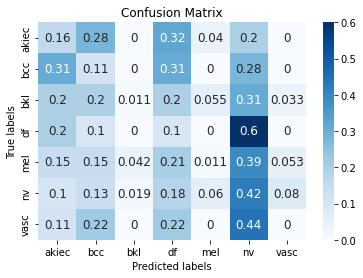

In [19]:
y_t = np.array(y_true)
y_p = np.array(y_pred)


SkinCancerCnn.metrics_scores(y_true, y_pred, 'metrics/FGSM/ResNet50_fgsm_metrics_0_5.txt')
SkinCancerCnn.confusion_matrix(y_true, y_pred, 'true', 'heatmaps/perturbation/ResNet50_fgsm_conf_mat_0_5.png')